##### Final Project AIT - 526

###### Vrishin Reddy Minkuri - G01444633
###### Rishitha Reddy Bitla - G01448537
###### Keerthana Reddy Kalva - G01448551 
###### Rohith Reddy Marlapally - G01450316

### Transformer Based Model (BERT)

In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available.")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")


CUDA is available.
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
import subprocess

try:
    # Run the nvidia-smi command
    result = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
    print(result.stdout)
except FileNotFoundError:
    print("nvidia-smi command not found. Ensure you have an NVIDIA GPU with the drivers installed.")


Tue Nov 26 15:52:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   60C    P8             16W /  115W |     612MiB /   6144MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import transformers

print(f"Running on transformers v{transformers.__version__}")

Running on transformers v4.46.0


# Required Libraries

In [5]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          PreTrainedModel, DistilBertModel, DistilBertForSequenceClassification,
                          TrainingArguments, Trainer)
from transformers.modeling_outputs import SequenceClassifierOutput

In [6]:
import pandas as pd
from datasets import Dataset
# Load your local CSV file
df = pd.read_csv(r'C:\Users\vrishin\Documents\AIT_526_MP\Emotion_Text.csv')


# Convert the DataFrame to a Hugging Face Dataset
emotions = Dataset.from_pandas(df)


In [7]:
emotions

Dataset({
    features: ['Sentiment_Text', 'Sentiment_label'],
    num_rows: 416809
})

In [8]:
df = emotions.to_pandas()

In [9]:
label_cols = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
len(label_cols)

6

In [10]:
id2label = {str(i):label for i, label in enumerate(label_cols)}
label2id = {label:str(i) for i, label in enumerate(label_cols)}

In [11]:
id2label

{'0': 'anger',
 '1': 'fear',
 '2': 'joy',
 '3': 'love',
 '4': 'sadness',
 '5': 'surprise'}

In [12]:
label2id

{'anger': '0',
 'fear': '1',
 'joy': '2',
 'love': '3',
 'sadness': '4',
 'surprise': '5'}

# Preprocessing Data

In [13]:
df = df.rename(columns={'Sentiment_label': 'labels'})


In [14]:
df.head()


,Sentiment_Text,labels
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [15]:
# take sample for quick prototyping
df_sample = df.sample(n=1575)
df_sample.shape

(1575, 2)

# Creating Train and Splits (80-20)

In [16]:
import numpy as np

# Generate a mask for an 80-20 split
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]


In [17]:
print("Training set shape:", df_train.shape)
print("Test set shape:", df_test.shape)


Training set shape: (333602, 2)
Test set shape: (83207, 2)


In [18]:
print(df.columns)


Index(['Sentiment_Text', 'labels'], dtype='object')


In [19]:
from sklearn.model_selection import train_test_split

# Stratified train-test split based on the 'labels' column
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)


# Tokenize and Encode

In [20]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [21]:
train_encodings = tokenizer(df_train["Sentiment_Text"].values.tolist(), truncation=True)
test_encodings = tokenizer(df_test["Sentiment_Text"].values.tolist(), truncation=True)


In [22]:
train_labels = df_train["labels"].values.tolist()
test_labels = df_test["labels"].values.tolist()

In [23]:
import numpy as np

# Function to convert labels to one-hot encoding
def one_hot_encode(labels, num_classes=6):
    one_hot_labels = []
    for label in labels:
        # If label is an integer (single label), convert to one-hot directly
        if isinstance(label, int):
            one_hot = [0] * num_classes
            one_hot[label] = 1
        # If label is a list (multi-label), one-hot encode each index in the list
        elif isinstance(label, list):
            one_hot = [0] * num_classes
            for idx in label:
                one_hot[idx] = 1
        else:
            raise TypeError("Label format not recognized.")
        one_hot_labels.append(one_hot)
    return one_hot_labels

# Apply one-hot encoding to train and test labels
train_labels = one_hot_encode(df_train['labels'].tolist(), num_classes=6)
test_labels = one_hot_encode(df_test['labels'].tolist(), num_classes=6)

# Verify one-hot encoding by printing a sample
print("Sample of train_labels after one-hot encoding:", train_labels[:6])  # Should show lists of length 6


Sample of train_labels after one-hot encoding: [[0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0]]


one_hot_encode -> Convert a list of numerical labels to a one-hot encoded format.
    
    Args:
    - labels (list of int or list of list of int): A list where each element is either an integer
      representing a single class or a list of integers for multiple classes.
    - num_classes (int): The total number of classes. This determines the length of the one-hot
      encoded lists.

    Returns:
    - one_hot_labels (list of list of int): A list of lists, where each sublist is a one-hot
      encoded representation of the corresponding label in the input list.
      
    Raises:
    - TypeError: If elements in the labels list are neither integers nor lists of integers.

class GoEmotionDataset(Dataset):
    A custom PyTorch Dataset class designed to handle encoding and labels of emotional data,
    suitable for training machine learning models that require input in tensor format.

    Attributes:
    - encodings (dict): Encoded text data, typically returned by a tokenizer or an encoder.
      The dictionary should have keys corresponding to tensor names (like 'input_ids', 'attention_mask')
      and values as lists or arrays of encoded representations.
    - labels (list or np.array): The labels corresponding to the input data, aligned by index.

    Methods:
    - __init__(self, encodings, labels): Initializes the dataset with encodings and labels.
    - __getitem__(self, idx): Returns the encoded inputs and labels at the specified index `idx` as tensors.
    - __len__(self): Returns the total number of items in the dataset.


In [24]:
# Dataset class to ensure labels are correctly shaped for multilabel classification
class GoEmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Ensure labels are float tensors for BCEWithLogitsLoss
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)  # Updated line for float tensor
        return item

    def __len__(self):
        return len(self.labels)

__init__ -> Initializes the GoEmotionDataset with encoded text data and labels.

        Args:
        - encodings (dict): The encoded data from a tokenizer, should include necessary inputs like
          'input_ids', 'attention_mask', etc., each as a list or array.
        - labels (list or np.array): The target labels for each input data point.


getitem -> Retrieves the dataset item at the specified index `idx` and returns it as a dictionary of tensors,
        including both the encoded data and labels, with labels cast to float tensors.

        Args:
        - idx (int): Index of the item to retrieve.

        Returns:
        - item (dict): A dictionary containing tensors for all inputs and the label. Inputs are returned
          as they are named in the `encodings` attribute. The label is returned under the key 'labels'
          and is converted to a float tensor for compatibility with loss functions.

len -> Returns the total number of items in the dataset.

        Returns:
        - length (int): The total number of labels, which corresponds to the total number of data points.

In [25]:
# Instantiate datasets after one-hot encoding labels
train_dataset = GoEmotionDataset(train_encodings, train_labels)
test_dataset = GoEmotionDataset(test_encodings, test_labels)


In [26]:
# Verify label shape to prevent runtime errors
print(f"Sample label shape for sanity check: {train_dataset[0]['labels'].shape}")  # Should be [6]

Sample label shape for sanity check: torch.Size([6])


In [27]:
train_dataset[0]

{'input_ids': tensor([  101,  1045,  2514,  2061,  3294,  1998,  6171, 10439,  2890,  7405,
          6024,  2000,  2031,  2032,  1999,  2026,  2166,   102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor([0., 1., 0., 0., 0., 0.])}

In [28]:
# sanity check
tokenizer.decode(train_dataset[0]["input_ids"])

'[CLS] i feel so completely and deeply appreciative to have him in my life [SEP]'

## Creating a custom model for training

In [29]:
class DistilBertForMultilabelSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
      super().__init__(config)

    def forward(self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.distilbert(input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict)

        hidden_state = outputs[0]
        pooled_output = hidden_state[:, 0]  
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = torch.nn.BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), 
                            labels.float().view(-1, self.num_labels))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions)

DistilBertForMultilabelSequenceClassification : -> This class extends DistilBertForSequenceClassification to support multi-label sequence classification,
    using binary cross-entropy loss for handling multiple labels per data point.

    Methods:
    - __init__(self, config): Initializes the model with the specified configuration.
    - forward(self, input_ids, attention_mask, head_mask, inputs_embeds, labels,
              output_attentions, output_hidden_states, return_dict): Defines the forward pass.

    Args:
    - config (DistilBertConfig): Configuration class instance for DistilBert.

    Forward Pass Inputs:
    - input_ids (torch.Tensor): Indices of input sequence tokens in the vocabulary.
    - attention_mask (torch.Tensor): Mask to avoid performing attention on padding token indices.
    - head_mask (torch.Tensor): Mask to nullify selected heads of the self-attention modules.
    - inputs_embeds (torch.Tensor): Optionally, instead of input_ids you can pass input embeddings.
    - labels (torch.Tensor): Labels for computing the loss when training.
    - output_attentions (bool): Whether to return the attentions tensors of all attention layers.
    - output_hidden_states (bool): Whether to return the hidden states of all layers.
    - return_dict (bool): Whether to return a `SequenceClassifierOutput` object.

    Returns:
    - outputs (SequenceClassifierOutput or tuple): Depending on `return_dict`, either returns
      a tuple consisting of loss, logits, and optional hidden states and attentions, or a 
      SequenceClassifierOutput object containing these fields.

In [30]:
num_labels=6
model = DistilBertForMultilabelSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to('cuda')

Some weights of DistilBertForMultilabelSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Verify label shape to prevent runtime errors
print(f"Sample label shape for sanity check: {train_dataset[0]['labels'].shape}")  # Should be [6]

Sample label shape for sanity check: torch.Size([6])


In [32]:
model.config.id2label = {
    "0": "anger",
    "1": "fear",
    "2": "joy",
    "3": "love",
    "4": "sadness",
    "5": "surprise"
},
model.config.label2id = {
    "anger": "0",
    "fear": "1",
    "joy": "2",
    "love": "3",
    "sadness": "4",
    "surprise": "5"
    }
model.config

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": [
    {
      "0": "anger",
      "1": "fear",
      "2": "joy",
      "3": "love",
      "4": "sadness",
      "5": "surprise"
    }
  ],
  "initializer_range": 0.02,
  "label2id": {
    "anger": "0",
    "fear": "1",
    "joy": "2",
    "love": "3",
    "sadness": "4",
    "surprise": "5"
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.46.0",
  "vocab_size": 30522
}

In [33]:
def accuracy_thresh(y_pred, y_true, thresh=0.5, sigmoid=True): 
    y_pred = torch.from_numpy(y_pred)
    y_true = torch.from_numpy(y_true)
    if sigmoid: 
      y_pred = y_pred.sigmoid()
    return ((y_pred>thresh)==y_true.bool()).float().mean().item()

In [34]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return {'accuracy_thresh': accuracy_thresh(predictions, labels)}

In [35]:
import os
batch_size = 16  

# Define logging steps
logging_steps = 100 

# Set up simpler paths for testing
base_output_dir = r"C:\temp\emotion_classifier_results"
logging_dir = os.path.join(base_output_dir, "runs")

# Ensure directories exist
os.makedirs(base_output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

# Initialize TrainingArguments with simplified paths
args = TrainingArguments(
    output_dir=base_output_dir,
    logging_dir=logging_dir,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=logging_steps,
)


In [36]:
from datasets import Dataset

# Assuming `train_encodings` and `train_labels` are prepared
train_data = {
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels,
}

train_dataset = Dataset.from_dict(train_data)

test_data = {
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": test_labels,
}

test_dataset = Dataset.from_dict(test_data)


In the code, we've set the number of epochs to 10 because increasing this value further, although it could lead to better training outcomes, also risks overfitting the model to the training data. Overfitting occurs when a model learns the details and noise in the training data to an extent that it negatively impacts the performance of the model on new data, thereby reducing its accuracy. Therefore, it's important to carefully consider the epoch count to balance between adequate training and avoiding overfitting.

In [37]:
from transformers import DataCollatorWithPadding

# Use DataCollatorWithPadding for automatic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator  # Replace `tokenizer` with `data_collator`
)


In [38]:
# sanity check that we can run evaluation
trainer.evaluate()

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.6868085861206055,
 'eval_model_preparation_time': 0.0021,
 'eval_accuracy_thresh': 0.5622406005859375,
 'eval_runtime': 112.165,
 'eval_samples_per_second': 743.209,
 'eval_steps_per_second': 46.458}

In [39]:
trainer.train()

  0%|          | 0/208410 [00:00<?, ?it/s]

{'loss': 0.3946, 'grad_norm': 1.493335485458374, 'learning_rate': 1.9990403531500407e-05, 'epoch': 0.0}
{'loss': 0.2508, 'grad_norm': 1.2678183317184448, 'learning_rate': 1.998080706300082e-05, 'epoch': 0.01}
{'loss': 0.1676, 'grad_norm': 2.6653695106506348, 'learning_rate': 1.9971210594501225e-05, 'epoch': 0.01}
{'loss': 0.1333, 'grad_norm': 2.522658348083496, 'learning_rate': 1.9961614126001633e-05, 'epoch': 0.02}
{'loss': 0.1011, 'grad_norm': 1.7615535259246826, 'learning_rate': 1.9952017657502042e-05, 'epoch': 0.02}
{'loss': 0.0896, 'grad_norm': 2.5232629776000977, 'learning_rate': 1.9942421189002447e-05, 'epoch': 0.03}
{'loss': 0.0852, 'grad_norm': 1.0879284143447876, 'learning_rate': 1.9932824720502856e-05, 'epoch': 0.03}
{'loss': 0.0839, 'grad_norm': 3.2060070037841797, 'learning_rate': 1.9923228252003265e-05, 'epoch': 0.04}
{'loss': 0.073, 'grad_norm': 0.7009857296943665, 'learning_rate': 1.9913631783503674e-05, 'epoch': 0.04}
{'loss': 0.0758, 'grad_norm': 0.6785999536514282, '

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.029289403930306435, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9806826710700989, 'eval_runtime': 135.9134, 'eval_samples_per_second': 613.346, 'eval_steps_per_second': 38.341, 'epoch': 1.0}
{'loss': 0.0269, 'grad_norm': 0.40000486373901367, 'learning_rate': 1.799433808358524e-05, 'epoch': 1.0}
{'loss': 0.0261, 'grad_norm': 0.1555389016866684, 'learning_rate': 1.798474161508565e-05, 'epoch': 1.01}
{'loss': 0.0293, 'grad_norm': 0.2322414368391037, 'learning_rate': 1.7975145146586058e-05, 'epoch': 1.01}
{'loss': 0.0316, 'grad_norm': 0.23954764008522034, 'learning_rate': 1.7965548678086467e-05, 'epoch': 1.02}
{'loss': 0.0281, 'grad_norm': 0.27725791931152344, 'learning_rate': 1.7955952209586872e-05, 'epoch': 1.02}
{'loss': 0.0288, 'grad_norm': 0.2160079926252365, 'learning_rate': 1.794635574108728e-05, 'epoch': 1.03}
{'loss': 0.0289, 'grad_norm': 0.11189930140972137, 'learning_rate': 1.793675927258769e-05, 'epoch': 1.03}
{'loss': 0.0266, 'grad_norm': 0

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.029090728610754013, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9805207252502441, 'eval_runtime': 174.0719, 'eval_samples_per_second': 478.894, 'eval_steps_per_second': 29.936, 'epoch': 2.0}
{'loss': 0.0248, 'grad_norm': 0.0015919513534754515, 'learning_rate': 1.5998272635670077e-05, 'epoch': 2.0}
{'loss': 0.0309, 'grad_norm': 0.2880290746688843, 'learning_rate': 1.5988676167170483e-05, 'epoch': 2.01}
{'loss': 0.0295, 'grad_norm': 0.0016188094159588218, 'learning_rate': 1.5979079698670888e-05, 'epoch': 2.01}
{'loss': 0.0277, 'grad_norm': 0.12825383245944977, 'learning_rate': 1.59694832301713e-05, 'epoch': 2.02}
{'loss': 0.0252, 'grad_norm': 0.0014668996445834637, 'learning_rate': 1.5959886761671706e-05, 'epoch': 2.02}
{'loss': 0.029, 'grad_norm': 0.2835482954978943, 'learning_rate': 1.5950290293172114e-05, 'epoch': 2.02}
{'loss': 0.0287, 'grad_norm': 0.0014125700108706951, 'learning_rate': 1.5940693824672523e-05, 'epoch': 2.03}
{'loss': 0.0251, 'gra

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.029385827481746674, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9808205962181091, 'eval_runtime': 145.3349, 'eval_samples_per_second': 573.586, 'eval_steps_per_second': 35.855, 'epoch': 3.0}
{'loss': 0.0272, 'grad_norm': 0.2565907835960388, 'learning_rate': 1.3992610719255314e-05, 'epoch': 3.0}
{'loss': 0.0249, 'grad_norm': 0.20952953398227692, 'learning_rate': 1.3983014250755722e-05, 'epoch': 3.01}
{'loss': 0.0253, 'grad_norm': 0.002806083532050252, 'learning_rate': 1.3973417782256132e-05, 'epoch': 3.01}
{'loss': 0.0296, 'grad_norm': 0.22168868780136108, 'learning_rate': 1.3963821313756537e-05, 'epoch': 3.02}
{'loss': 0.0237, 'grad_norm': 0.12388227134943008, 'learning_rate': 1.3954224845256948e-05, 'epoch': 3.02}
{'loss': 0.0275, 'grad_norm': 0.1844853162765503, 'learning_rate': 1.3944628376757355e-05, 'epoch': 3.03}
{'loss': 0.0247, 'grad_norm': 0.1324130743741989, 'learning_rate': 1.3935031908257762e-05, 'epoch': 3.03}
{'loss': 0.0275, 'grad_nor

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.030957303941249847, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9808365702629089, 'eval_runtime': 176.6109, 'eval_samples_per_second': 472.009, 'eval_steps_per_second': 29.506, 'epoch': 4.0}
{'loss': 0.0271, 'grad_norm': 0.1321868747472763, 'learning_rate': 1.1996545271340148e-05, 'epoch': 4.0}
{'loss': 0.0226, 'grad_norm': 0.12522007524967194, 'learning_rate': 1.1986948802840557e-05, 'epoch': 4.01}
{'loss': 0.0275, 'grad_norm': 0.11807307600975037, 'learning_rate': 1.1977352334340964e-05, 'epoch': 4.01}
{'loss': 0.0316, 'grad_norm': 0.3175891041755676, 'learning_rate': 1.196775586584137e-05, 'epoch': 4.02}
{'loss': 0.0262, 'grad_norm': 0.12636137008666992, 'learning_rate': 1.195815939734178e-05, 'epoch': 4.02}
{'loss': 0.0258, 'grad_norm': 0.0007076747133396566, 'learning_rate': 1.1948562928842187e-05, 'epoch': 4.03}
{'loss': 0.0285, 'grad_norm': 0.20320583879947662, 'learning_rate': 1.1938966460342595e-05, 'epoch': 4.03}
{'loss': 0.024, 'grad_norm

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.031106937676668167, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9806066751480103, 'eval_runtime': 95.4546, 'eval_samples_per_second': 873.315, 'eval_steps_per_second': 54.591, 'epoch': 5.0}
{'loss': 0.024, 'grad_norm': 0.18550235033035278, 'learning_rate': 9.990883354925388e-06, 'epoch': 5.0}
{'loss': 0.026, 'grad_norm': 0.1896197348833084, 'learning_rate': 9.981286886425796e-06, 'epoch': 5.01}
{'loss': 0.0238, 'grad_norm': 0.21567849814891815, 'learning_rate': 9.971690417926204e-06, 'epoch': 5.01}
{'loss': 0.0227, 'grad_norm': 0.20156118273735046, 'learning_rate': 9.962093949426613e-06, 'epoch': 5.02}
{'loss': 0.0244, 'grad_norm': 0.14242538809776306, 'learning_rate': 9.952497480927018e-06, 'epoch': 5.02}
{'loss': 0.0256, 'grad_norm': 0.3247907757759094, 'learning_rate': 9.942901012427427e-06, 'epoch': 5.03}
{'loss': 0.0266, 'grad_norm': 0.12626826763153076, 'learning_rate': 9.933304543927836e-06, 'epoch': 5.03}
{'loss': 0.0277, 'grad_norm': 0.0008

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.032747119665145874, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9810325503349304, 'eval_runtime': 94.1705, 'eval_samples_per_second': 885.224, 'eval_steps_per_second': 55.336, 'epoch': 6.0}
{'loss': 0.0256, 'grad_norm': 0.21806341409683228, 'learning_rate': 7.99481790701022e-06, 'epoch': 6.0}
{'loss': 0.0255, 'grad_norm': 0.23658686876296997, 'learning_rate': 7.985221438510629e-06, 'epoch': 6.01}
{'loss': 0.0221, 'grad_norm': 0.20066989958286285, 'learning_rate': 7.975624970011036e-06, 'epoch': 6.01}
{'loss': 0.0268, 'grad_norm': 0.23055420815944672, 'learning_rate': 7.966028501511445e-06, 'epoch': 6.02}
{'loss': 0.0251, 'grad_norm': 0.18986356258392334, 'learning_rate': 7.956432033011852e-06, 'epoch': 6.02}
{'loss': 0.0233, 'grad_norm': 0.22261780500411987, 'learning_rate': 7.946835564512259e-06, 'epoch': 6.03}
{'loss': 0.0263, 'grad_norm': 0.15140080451965332, 'learning_rate': 7.937239096012668e-06, 'epoch': 6.03}
{'loss': 0.0259, 'grad_norm': 0.1

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.032657429575920105, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9805107116699219, 'eval_runtime': 94.9496, 'eval_samples_per_second': 877.961, 'eval_steps_per_second': 54.882, 'epoch': 7.0}
{'loss': 0.0243, 'grad_norm': 0.1414102166891098, 'learning_rate': 5.998752459095053e-06, 'epoch': 7.0}
{'loss': 0.0279, 'grad_norm': 0.13847659528255463, 'learning_rate': 5.989155990595461e-06, 'epoch': 7.01}
{'loss': 0.0228, 'grad_norm': 0.3215486705303192, 'learning_rate': 5.979559522095869e-06, 'epoch': 7.01}
{'loss': 0.0283, 'grad_norm': 0.3750891387462616, 'learning_rate': 5.9699630535962775e-06, 'epoch': 7.02}
{'loss': 0.0272, 'grad_norm': 0.14126917719841003, 'learning_rate': 5.960366585096685e-06, 'epoch': 7.02}
{'loss': 0.0228, 'grad_norm': 0.14297518134117126, 'learning_rate': 5.950770116597093e-06, 'epoch': 7.02}
{'loss': 0.0264, 'grad_norm': 0.2619728744029999, 'learning_rate': 5.9411736480975e-06, 'epoch': 7.03}
{'loss': 0.0264, 'grad_norm': 0.15945

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.033312954008579254, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.980708658695221, 'eval_runtime': 94.2202, 'eval_samples_per_second': 884.757, 'eval_steps_per_second': 55.307, 'epoch': 8.0}
{'loss': 0.024, 'grad_norm': 0.13345275819301605, 'learning_rate': 3.993090542680294e-06, 'epoch': 8.0}
{'loss': 0.024, 'grad_norm': 0.00045086556929163635, 'learning_rate': 3.983494074180701e-06, 'epoch': 8.01}
{'loss': 0.0253, 'grad_norm': 0.23150719702243805, 'learning_rate': 3.973897605681109e-06, 'epoch': 8.01}
{'loss': 0.0241, 'grad_norm': 0.18039172887802124, 'learning_rate': 3.964301137181518e-06, 'epoch': 8.02}
{'loss': 0.026, 'grad_norm': 0.09927968680858612, 'learning_rate': 3.954704668681925e-06, 'epoch': 8.02}
{'loss': 0.0226, 'grad_norm': 0.1871543973684311, 'learning_rate': 3.945108200182333e-06, 'epoch': 8.03}
{'loss': 0.0244, 'grad_norm': 0.00028976384783163667, 'learning_rate': 3.935511731682741e-06, 'epoch': 8.03}
{'loss': 0.0268, 'grad_norm': 0

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.03393080085515976, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9807406067848206, 'eval_runtime': 92.8569, 'eval_samples_per_second': 897.747, 'eval_steps_per_second': 56.119, 'epoch': 9.0}
{'loss': 0.0253, 'grad_norm': 0.13820235431194305, 'learning_rate': 1.9970250947651264e-06, 'epoch': 9.0}
{'loss': 0.022, 'grad_norm': 0.0002969189081341028, 'learning_rate': 1.9874286262655348e-06, 'epoch': 9.01}
{'loss': 0.0243, 'grad_norm': 0.16384673118591309, 'learning_rate': 1.9778321577659423e-06, 'epoch': 9.01}
{'loss': 0.0241, 'grad_norm': 0.1957482099533081, 'learning_rate': 1.96823568926635e-06, 'epoch': 9.02}
{'loss': 0.0233, 'grad_norm': 0.21394522488117218, 'learning_rate': 1.958639220766758e-06, 'epoch': 9.02}
{'loss': 0.0274, 'grad_norm': 0.2302674651145935, 'learning_rate': 1.949042752267166e-06, 'epoch': 9.03}
{'loss': 0.0247, 'grad_norm': 0.19122391939163208, 'learning_rate': 1.9394462837675735e-06, 'epoch': 9.03}
{'loss': 0.0287, 'grad_norm': 0

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.03432799130678177, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9802168011665344, 'eval_runtime': 88.92, 'eval_samples_per_second': 937.495, 'eval_steps_per_second': 58.603, 'epoch': 10.0}
{'train_runtime': 18402.3525, 'train_samples_per_second': 181.198, 'train_steps_per_second': 11.325, 'train_loss': 0.027947163957648267, 'epoch': 10.0}


TrainOutput(global_step=208410, training_loss=0.027947163957648267, metrics={'train_runtime': 18402.3525, 'train_samples_per_second': 181.198, 'train_steps_per_second': 11.325, 'total_flos': 4.0766941605709224e+16, 'train_loss': 0.027947163957648267, 'epoch': 10.0})

In [40]:
# Save the model and tokenizer
model_path = r"C:\temp\model_outputs\emotion_classifier_model"
tokenizer_path = r"C:\temp\model_outputs\emotion_classifier_tokenizer"

os.makedirs(model_path, exist_ok=True)
os.makedirs(tokenizer_path, exist_ok=True)

trainer.model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

print("Model and tokenizer have been saved successfully.")

Model and tokenizer have been saved successfully.


In [41]:
# sanity check that we can run evaluation
trainer.evaluate()

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.03432799130678177,
 'eval_model_preparation_time': 0.0021,
 'eval_accuracy_thresh': 0.9802168011665344,
 'eval_runtime': 89.9095,
 'eval_samples_per_second': 927.177,
 'eval_steps_per_second': 57.958,
 'epoch': 10.0}

  0%|          | 0/5211 [00:00<?, ?it/s]

  0%|          | 0/208410 [00:00<?, ?it/s]

{'loss': 0.0244, 'grad_norm': 0.22758084535598755, 'learning_rate': 1.9990403531500407e-05, 'epoch': 0.0}
{'loss': 0.0254, 'grad_norm': 0.18329976499080658, 'learning_rate': 1.998080706300082e-05, 'epoch': 0.01}
{'loss': 0.0234, 'grad_norm': 0.300314724445343, 'learning_rate': 1.9971210594501225e-05, 'epoch': 0.01}
{'loss': 0.0266, 'grad_norm': 0.00047423187061212957, 'learning_rate': 1.9961614126001633e-05, 'epoch': 0.02}
{'loss': 0.0272, 'grad_norm': 0.13451753556728363, 'learning_rate': 1.9952017657502042e-05, 'epoch': 0.02}
{'loss': 0.0234, 'grad_norm': 0.0005489984760060906, 'learning_rate': 1.9942421189002447e-05, 'epoch': 0.03}
{'loss': 0.0287, 'grad_norm': 0.2028975933790207, 'learning_rate': 1.9932824720502856e-05, 'epoch': 0.03}
{'loss': 0.0329, 'grad_norm': 0.27704623341560364, 'learning_rate': 1.9923228252003265e-05, 'epoch': 0.04}
{'loss': 0.0246, 'grad_norm': 0.0003638149064499885, 'learning_rate': 1.9913631783503674e-05, 'epoch': 0.04}
{'loss': 0.0306, 'grad_norm': 0.212

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.0334666445851326, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9805186986923218, 'eval_runtime': 89.9146, 'eval_samples_per_second': 927.124, 'eval_steps_per_second': 57.955, 'epoch': 1.0}
{'loss': 0.0243, 'grad_norm': 0.3123335540294647, 'learning_rate': 1.799433808358524e-05, 'epoch': 1.0}
{'loss': 0.0236, 'grad_norm': 0.13090448081493378, 'learning_rate': 1.798474161508565e-05, 'epoch': 1.01}
{'loss': 0.0255, 'grad_norm': 0.218548983335495, 'learning_rate': 1.7975145146586058e-05, 'epoch': 1.01}
{'loss': 0.0271, 'grad_norm': 0.1393192708492279, 'learning_rate': 1.7965548678086467e-05, 'epoch': 1.02}
{'loss': 0.0231, 'grad_norm': 0.09616929292678833, 'learning_rate': 1.7955952209586872e-05, 'epoch': 1.02}
{'loss': 0.0297, 'grad_norm': 0.20932239294052124, 'learning_rate': 1.794635574108728e-05, 'epoch': 1.03}
{'loss': 0.0286, 'grad_norm': 0.14000748097896576, 'learning_rate': 1.793675927258769e-05, 'epoch': 1.03}
{'loss': 0.0252, 'grad_norm': 0.307

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.03291510045528412, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9806126952171326, 'eval_runtime': 91.2165, 'eval_samples_per_second': 913.891, 'eval_steps_per_second': 57.128, 'epoch': 2.0}
{'loss': 0.028, 'grad_norm': 6.1966447830200195, 'learning_rate': 1.5998272635670077e-05, 'epoch': 2.0}
{'loss': 0.0283, 'grad_norm': 0.2665279507637024, 'learning_rate': 1.5988676167170483e-05, 'epoch': 2.01}
{'loss': 0.0277, 'grad_norm': 0.0009106873767450452, 'learning_rate': 1.5979079698670888e-05, 'epoch': 2.01}
{'loss': 0.0261, 'grad_norm': 0.16471070051193237, 'learning_rate': 1.59694832301713e-05, 'epoch': 2.02}
{'loss': 0.0237, 'grad_norm': 0.0018086903728544712, 'learning_rate': 1.5959886761671706e-05, 'epoch': 2.02}
{'loss': 0.0257, 'grad_norm': 0.21182270348072052, 'learning_rate': 1.5950290293172114e-05, 'epoch': 2.02}
{'loss': 0.0276, 'grad_norm': 0.00030285821412689984, 'learning_rate': 1.5940693824672523e-05, 'epoch': 2.03}
{'loss': 0.024, 'grad_no

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.03353312239050865, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.980420708656311, 'eval_runtime': 94.737, 'eval_samples_per_second': 879.93, 'eval_steps_per_second': 55.005, 'epoch': 3.0}
{'loss': 0.028, 'grad_norm': 0.24644775688648224, 'learning_rate': 1.3992610719255314e-05, 'epoch': 3.0}
{'loss': 0.0244, 'grad_norm': 0.1945546567440033, 'learning_rate': 1.3983014250755722e-05, 'epoch': 3.01}
{'loss': 0.0246, 'grad_norm': 0.00021377623488660902, 'learning_rate': 1.3973417782256132e-05, 'epoch': 3.01}
{'loss': 0.0288, 'grad_norm': 0.20723474025726318, 'learning_rate': 1.3963821313756537e-05, 'epoch': 3.02}
{'loss': 0.0233, 'grad_norm': 0.09993251413106918, 'learning_rate': 1.3954224845256948e-05, 'epoch': 3.02}
{'loss': 0.0247, 'grad_norm': 0.1786961704492569, 'learning_rate': 1.3944628376757355e-05, 'epoch': 3.03}
{'loss': 0.024, 'grad_norm': 0.13615185022354126, 'learning_rate': 1.3935031908257762e-05, 'epoch': 3.03}
{'loss': 0.0281, 'grad_norm': 

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.033953774720430374, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.980738639831543, 'eval_runtime': 93.9655, 'eval_samples_per_second': 887.156, 'eval_steps_per_second': 55.457, 'epoch': 4.0}
{'loss': 0.0265, 'grad_norm': 0.1479400396347046, 'learning_rate': 1.1996545271340148e-05, 'epoch': 4.0}
{'loss': 0.0218, 'grad_norm': 0.15568585693836212, 'learning_rate': 1.1986948802840557e-05, 'epoch': 4.01}
{'loss': 0.0272, 'grad_norm': 0.12335113435983658, 'learning_rate': 1.1977352334340964e-05, 'epoch': 4.01}
{'loss': 0.0291, 'grad_norm': 0.3013347387313843, 'learning_rate': 1.196775586584137e-05, 'epoch': 4.02}
{'loss': 0.0238, 'grad_norm': 0.15760213136672974, 'learning_rate': 1.195815939734178e-05, 'epoch': 4.02}
{'loss': 0.0271, 'grad_norm': 0.01528739184141159, 'learning_rate': 1.1948562928842187e-05, 'epoch': 4.03}
{'loss': 0.0285, 'grad_norm': 0.20865480601787567, 'learning_rate': 1.1938966460342595e-05, 'epoch': 4.03}
{'loss': 0.0239, 'grad_norm': 

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.0337592251598835, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9803407788276672, 'eval_runtime': 107.0746, 'eval_samples_per_second': 778.542, 'eval_steps_per_second': 48.667, 'epoch': 5.0}
{'loss': 0.025, 'grad_norm': 0.200661301612854, 'learning_rate': 9.990883354925388e-06, 'epoch': 5.0}
{'loss': 0.0255, 'grad_norm': 0.182975172996521, 'learning_rate': 9.981286886425796e-06, 'epoch': 5.01}
{'loss': 0.0237, 'grad_norm': 0.22366443276405334, 'learning_rate': 9.971690417926204e-06, 'epoch': 5.01}
{'loss': 0.0223, 'grad_norm': 0.18602535128593445, 'learning_rate': 9.962093949426613e-06, 'epoch': 5.02}
{'loss': 0.0242, 'grad_norm': 0.14442330598831177, 'learning_rate': 9.952497480927018e-06, 'epoch': 5.02}
{'loss': 0.025, 'grad_norm': 0.34058085083961487, 'learning_rate': 9.942901012427427e-06, 'epoch': 5.03}
{'loss': 0.0262, 'grad_norm': 0.1345134675502777, 'learning_rate': 9.933304543927836e-06, 'epoch': 5.03}
{'loss': 0.0272, 'grad_norm': 0.00422695

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.03482811897993088, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.980764627456665, 'eval_runtime': 95.617, 'eval_samples_per_second': 871.832, 'eval_steps_per_second': 54.499, 'epoch': 6.0}
{'loss': 0.0254, 'grad_norm': 0.2384176403284073, 'learning_rate': 7.99481790701022e-06, 'epoch': 6.0}
{'loss': 0.0251, 'grad_norm': 0.22728657722473145, 'learning_rate': 7.985221438510629e-06, 'epoch': 6.01}
{'loss': 0.0239, 'grad_norm': 0.2053144872188568, 'learning_rate': 7.975624970011036e-06, 'epoch': 6.01}
{'loss': 0.0265, 'grad_norm': 0.19472213089466095, 'learning_rate': 7.966028501511445e-06, 'epoch': 6.02}
{'loss': 0.0238, 'grad_norm': 0.17255674302577972, 'learning_rate': 7.956432033011852e-06, 'epoch': 6.02}
{'loss': 0.0242, 'grad_norm': 0.23688705265522003, 'learning_rate': 7.946835564512259e-06, 'epoch': 6.03}
{'loss': 0.0261, 'grad_norm': 0.1316239833831787, 'learning_rate': 7.937239096012668e-06, 'epoch': 6.03}
{'loss': 0.0248, 'grad_norm': 0.2063880

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.03442976996302605, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9802048206329346, 'eval_runtime': 95.7339, 'eval_samples_per_second': 870.768, 'eval_steps_per_second': 54.432, 'epoch': 7.0}
{'loss': 0.0241, 'grad_norm': 0.13236428797245026, 'learning_rate': 5.998752459095053e-06, 'epoch': 7.0}
{'loss': 0.0274, 'grad_norm': 0.1437506079673767, 'learning_rate': 5.989155990595461e-06, 'epoch': 7.01}
{'loss': 0.0225, 'grad_norm': 0.3094009459018707, 'learning_rate': 5.979559522095869e-06, 'epoch': 7.01}
{'loss': 0.0277, 'grad_norm': 0.3535928428173065, 'learning_rate': 5.9699630535962775e-06, 'epoch': 7.02}
{'loss': 0.0256, 'grad_norm': 0.13869711756706238, 'learning_rate': 5.960366585096685e-06, 'epoch': 7.02}
{'loss': 0.0225, 'grad_norm': 0.1567666083574295, 'learning_rate': 5.950770116597093e-06, 'epoch': 7.02}
{'loss': 0.0269, 'grad_norm': 0.2507181465625763, 'learning_rate': 5.9411736480975e-06, 'epoch': 7.03}
{'loss': 0.0262, 'grad_norm': 0.1517063

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.03588471934199333, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9804087281227112, 'eval_runtime': 93.6275, 'eval_samples_per_second': 890.358, 'eval_steps_per_second': 55.657, 'epoch': 8.0}
{'loss': 0.0238, 'grad_norm': 0.13391508162021637, 'learning_rate': 3.993090542680294e-06, 'epoch': 8.0}
{'loss': 0.0237, 'grad_norm': 0.00019132655870635062, 'learning_rate': 3.983494074180701e-06, 'epoch': 8.01}
{'loss': 0.0252, 'grad_norm': 0.23516547679901123, 'learning_rate': 3.973897605681109e-06, 'epoch': 8.01}
{'loss': 0.0235, 'grad_norm': 0.18617606163024902, 'learning_rate': 3.964301137181518e-06, 'epoch': 8.02}
{'loss': 0.0261, 'grad_norm': 0.1252870410680771, 'learning_rate': 3.954704668681925e-06, 'epoch': 8.02}
{'loss': 0.0241, 'grad_norm': 0.18349717557430267, 'learning_rate': 3.945108200182333e-06, 'epoch': 8.03}
{'loss': 0.0244, 'grad_norm': 0.0002967317996080965, 'learning_rate': 3.935511731682741e-06, 'epoch': 8.03}
{'loss': 0.0268, 'grad_norm':

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.03609481826424599, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9799628853797913, 'eval_runtime': 95.1584, 'eval_samples_per_second': 876.034, 'eval_steps_per_second': 54.761, 'epoch': 9.0}
{'loss': 0.0256, 'grad_norm': 0.1510930061340332, 'learning_rate': 1.9970250947651264e-06, 'epoch': 9.0}
{'loss': 0.0218, 'grad_norm': 0.0002776443143375218, 'learning_rate': 1.9874286262655348e-06, 'epoch': 9.01}
{'loss': 0.0243, 'grad_norm': 0.15025588870048523, 'learning_rate': 1.9778321577659423e-06, 'epoch': 9.01}
{'loss': 0.024, 'grad_norm': 0.19464530050754547, 'learning_rate': 1.96823568926635e-06, 'epoch': 9.02}
{'loss': 0.0231, 'grad_norm': 0.23598580062389374, 'learning_rate': 1.958639220766758e-06, 'epoch': 9.02}
{'loss': 0.0272, 'grad_norm': 0.252691388130188, 'learning_rate': 1.949042752267166e-06, 'epoch': 9.03}
{'loss': 0.0246, 'grad_norm': 0.20020753145217896, 'learning_rate': 1.9394462837675735e-06, 'epoch': 9.03}
{'loss': 0.0281, 'grad_norm': 0.

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.03708327189087868, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9790571928024292, 'eval_runtime': 97.3784, 'eval_samples_per_second': 856.062, 'eval_steps_per_second': 53.513, 'epoch': 10.0}
{'train_runtime': 15355.3226, 'train_samples_per_second': 217.154, 'train_steps_per_second': 13.572, 'train_loss': 0.02585297662779624, 'epoch': 10.0}


  0%|          | 0/5211 [00:00<?, ?it/s]

  0%|          | 0/208410 [00:00<?, ?it/s]

{'loss': 0.0238, 'grad_norm': 0.2230585664510727, 'learning_rate': 1.9990403531500407e-05, 'epoch': 0.0}
{'loss': 0.0247, 'grad_norm': 0.1901252567768097, 'learning_rate': 1.998080706300082e-05, 'epoch': 0.01}
{'loss': 0.023, 'grad_norm': 0.2948341369628906, 'learning_rate': 1.9971210594501225e-05, 'epoch': 0.01}
{'loss': 0.0263, 'grad_norm': 0.0002868481387849897, 'learning_rate': 1.9961614126001633e-05, 'epoch': 0.02}
{'loss': 0.0279, 'grad_norm': 0.12777024507522583, 'learning_rate': 1.9952017657502042e-05, 'epoch': 0.02}
{'loss': 0.0223, 'grad_norm': 0.00018806154548656195, 'learning_rate': 1.9942421189002447e-05, 'epoch': 0.03}
{'loss': 0.0266, 'grad_norm': 0.22324025630950928, 'learning_rate': 1.9932824720502856e-05, 'epoch': 0.03}
{'loss': 0.0284, 'grad_norm': 0.259456604719162, 'learning_rate': 1.9923228252003265e-05, 'epoch': 0.04}
{'loss': 0.0241, 'grad_norm': 0.00012900539149995893, 'learning_rate': 1.9913631783503674e-05, 'epoch': 0.04}
{'loss': 0.0284, 'grad_norm': 0.00033

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.036659158766269684, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9803707599639893, 'eval_runtime': 98.1537, 'eval_samples_per_second': 849.301, 'eval_steps_per_second': 53.09, 'epoch': 1.0}
{'loss': 0.0231, 'grad_norm': 0.33635687828063965, 'learning_rate': 1.799433808358524e-05, 'epoch': 1.0}
{'loss': 0.0233, 'grad_norm': 0.13263696432113647, 'learning_rate': 1.798474161508565e-05, 'epoch': 1.01}
{'loss': 0.0264, 'grad_norm': 0.2502078711986542, 'learning_rate': 1.7975145146586058e-05, 'epoch': 1.01}
{'loss': 0.0277, 'grad_norm': 0.1478397399187088, 'learning_rate': 1.7965548678086467e-05, 'epoch': 1.02}
{'loss': 0.0232, 'grad_norm': 0.10139109194278717, 'learning_rate': 1.7955952209586872e-05, 'epoch': 1.02}
{'loss': 0.0267, 'grad_norm': 0.19269639253616333, 'learning_rate': 1.794635574108728e-05, 'epoch': 1.03}
{'loss': 0.0266, 'grad_norm': 0.1368720978498459, 'learning_rate': 1.793675927258769e-05, 'epoch': 1.03}
{'loss': 0.025, 'grad_norm': 0.31

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.036009546369314194, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9803927540779114, 'eval_runtime': 98.6577, 'eval_samples_per_second': 844.962, 'eval_steps_per_second': 52.819, 'epoch': 2.0}
{'loss': 0.0232, 'grad_norm': 0.00023349554976448417, 'learning_rate': 1.5998272635670077e-05, 'epoch': 2.0}
{'loss': 0.0273, 'grad_norm': 0.29529693722724915, 'learning_rate': 1.5988676167170483e-05, 'epoch': 2.01}
{'loss': 0.0262, 'grad_norm': 0.0001446436799596995, 'learning_rate': 1.5979079698670888e-05, 'epoch': 2.01}
{'loss': 0.0281, 'grad_norm': 0.133449524641037, 'learning_rate': 1.59694832301713e-05, 'epoch': 2.02}
{'loss': 0.0246, 'grad_norm': 0.0002171482628909871, 'learning_rate': 1.5959886761671706e-05, 'epoch': 2.02}
{'loss': 0.0258, 'grad_norm': 0.18976326286792755, 'learning_rate': 1.5950290293172114e-05, 'epoch': 2.02}
{'loss': 0.0258, 'grad_norm': 0.00021991424728184938, 'learning_rate': 1.5940693824672523e-05, 'epoch': 2.03}
{'loss': 0.0242, 'g

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.03551565855741501, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9804707169532776, 'eval_runtime': 99.1357, 'eval_samples_per_second': 840.888, 'eval_steps_per_second': 52.564, 'epoch': 3.0}
{'loss': 0.0274, 'grad_norm': 0.2536066770553589, 'learning_rate': 1.3992610719255314e-05, 'epoch': 3.0}
{'loss': 0.0236, 'grad_norm': 0.21907451748847961, 'learning_rate': 1.3983014250755722e-05, 'epoch': 3.01}
{'loss': 0.0246, 'grad_norm': 0.0003661574446596205, 'learning_rate': 1.3973417782256132e-05, 'epoch': 3.01}
{'loss': 0.0297, 'grad_norm': 0.22395524382591248, 'learning_rate': 1.3963821313756537e-05, 'epoch': 3.02}
{'loss': 0.0232, 'grad_norm': 0.11902517080307007, 'learning_rate': 1.3954224845256948e-05, 'epoch': 3.02}
{'loss': 0.0244, 'grad_norm': 0.18606339395046234, 'learning_rate': 1.3944628376757355e-05, 'epoch': 3.03}
{'loss': 0.0238, 'grad_norm': 0.13577860593795776, 'learning_rate': 1.3935031908257762e-05, 'epoch': 3.03}
{'loss': 0.0244, 'grad_no

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.037352003157138824, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.979824960231781, 'eval_runtime': 98.7207, 'eval_samples_per_second': 844.423, 'eval_steps_per_second': 52.785, 'epoch': 4.0}
{'loss': 0.0266, 'grad_norm': 0.14724400639533997, 'learning_rate': 1.1996545271340148e-05, 'epoch': 4.0}
{'loss': 0.0225, 'grad_norm': 0.1435312032699585, 'learning_rate': 1.1986948802840557e-05, 'epoch': 4.01}
{'loss': 0.0267, 'grad_norm': 0.13987593352794647, 'learning_rate': 1.1977352334340964e-05, 'epoch': 4.01}
{'loss': 0.0268, 'grad_norm': 0.3033425509929657, 'learning_rate': 1.196775586584137e-05, 'epoch': 4.02}
{'loss': 0.0237, 'grad_norm': 0.15798954665660858, 'learning_rate': 1.195815939734178e-05, 'epoch': 4.02}
{'loss': 0.0251, 'grad_norm': 0.00021009723423048854, 'learning_rate': 1.1948562928842187e-05, 'epoch': 4.03}
{'loss': 0.0278, 'grad_norm': 0.19965863227844238, 'learning_rate': 1.1938966460342595e-05, 'epoch': 4.03}
{'loss': 0.0237, 'grad_norm

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.037905603647232056, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9797789454460144, 'eval_runtime': 99.2456, 'eval_samples_per_second': 839.956, 'eval_steps_per_second': 52.506, 'epoch': 5.0}
{'loss': 0.0242, 'grad_norm': 0.20598864555358887, 'learning_rate': 9.990883354925388e-06, 'epoch': 5.0}
{'loss': 0.0253, 'grad_norm': 0.19457703828811646, 'learning_rate': 9.981286886425796e-06, 'epoch': 5.01}
{'loss': 0.0242, 'grad_norm': 0.3469977378845215, 'learning_rate': 9.971690417926204e-06, 'epoch': 5.01}
{'loss': 0.0224, 'grad_norm': 0.2087710052728653, 'learning_rate': 9.962093949426613e-06, 'epoch': 5.02}
{'loss': 0.0239, 'grad_norm': 0.46541255712509155, 'learning_rate': 9.952497480927018e-06, 'epoch': 5.02}
{'loss': 0.0249, 'grad_norm': 0.31600263714790344, 'learning_rate': 9.942901012427427e-06, 'epoch': 5.03}
{'loss': 0.0259, 'grad_norm': 0.1443164348602295, 'learning_rate': 9.933304543927836e-06, 'epoch': 5.03}
{'loss': 0.027, 'grad_norm': 0.0001

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.04036307334899902, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9792551398277283, 'eval_runtime': 99.2722, 'eval_samples_per_second': 839.731, 'eval_steps_per_second': 52.492, 'epoch': 6.0}
{'loss': 0.0265, 'grad_norm': 0.24732322990894318, 'learning_rate': 7.99481790701022e-06, 'epoch': 6.0}
{'loss': 0.0259, 'grad_norm': 1.6780842542648315, 'learning_rate': 7.985221438510629e-06, 'epoch': 6.01}
{'loss': 0.0217, 'grad_norm': 21.86241340637207, 'learning_rate': 7.975624970011036e-06, 'epoch': 6.01}
{'loss': 0.028, 'grad_norm': 0.21163775026798248, 'learning_rate': 7.966028501511445e-06, 'epoch': 6.02}
{'loss': 0.0238, 'grad_norm': 0.18742318451404572, 'learning_rate': 7.956432033011852e-06, 'epoch': 6.02}
{'loss': 0.0233, 'grad_norm': 0.2228991985321045, 'learning_rate': 7.946835564512259e-06, 'epoch': 6.03}
{'loss': 0.0261, 'grad_norm': 0.1695391982793808, 'learning_rate': 7.937239096012668e-06, 'epoch': 6.03}
{'loss': 0.0242, 'grad_norm': 0.21767292

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.04391462355852127, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9782274961471558, 'eval_runtime': 98.9908, 'eval_samples_per_second': 842.118, 'eval_steps_per_second': 52.641, 'epoch': 7.0}
{'loss': 0.0244, 'grad_norm': 0.13402016460895538, 'learning_rate': 5.998752459095053e-06, 'epoch': 7.0}
{'loss': 0.0273, 'grad_norm': 0.1472688615322113, 'learning_rate': 5.989155990595461e-06, 'epoch': 7.01}
{'loss': 0.0221, 'grad_norm': 0.3534706234931946, 'learning_rate': 5.979559522095869e-06, 'epoch': 7.01}
{'loss': 0.0268, 'grad_norm': 0.3671954870223999, 'learning_rate': 5.9699630535962775e-06, 'epoch': 7.02}
{'loss': 0.0249, 'grad_norm': 0.12282516062259674, 'learning_rate': 5.960366585096685e-06, 'epoch': 7.02}
{'loss': 0.0223, 'grad_norm': 0.14799948036670685, 'learning_rate': 5.950770116597093e-06, 'epoch': 7.02}
{'loss': 0.0271, 'grad_norm': 0.34694552421569824, 'learning_rate': 5.9411736480975e-06, 'epoch': 7.03}
{'loss': 0.0252, 'grad_norm': 0.16389

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.04619332775473595, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9769439101219177, 'eval_runtime': 114.2851, 'eval_samples_per_second': 729.422, 'eval_steps_per_second': 45.597, 'epoch': 8.0}
{'loss': 0.0236, 'grad_norm': 0.1486404836177826, 'learning_rate': 3.993090542680294e-06, 'epoch': 8.0}
{'loss': 0.0233, 'grad_norm': 9.260229126084596e-05, 'learning_rate': 3.983494074180701e-06, 'epoch': 8.01}
{'loss': 0.0245, 'grad_norm': 0.2863125205039978, 'learning_rate': 3.973897605681109e-06, 'epoch': 8.01}
{'loss': 0.0228, 'grad_norm': 0.18849946558475494, 'learning_rate': 3.964301137181518e-06, 'epoch': 8.02}
{'loss': 0.0253, 'grad_norm': 0.11088395863771439, 'learning_rate': 3.954704668681925e-06, 'epoch': 8.02}
{'loss': 0.0221, 'grad_norm': 0.21114271879196167, 'learning_rate': 3.945108200182333e-06, 'epoch': 8.03}
{'loss': 0.0257, 'grad_norm': 0.00019471105770207942, 'learning_rate': 3.935511731682741e-06, 'epoch': 8.03}
{'loss': 0.026, 'grad_norm': 

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.04836930334568024, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.975950300693512, 'eval_runtime': 112.4811, 'eval_samples_per_second': 741.12, 'eval_steps_per_second': 46.328, 'epoch': 9.0}
{'loss': 0.0256, 'grad_norm': 0.1388654261827469, 'learning_rate': 1.9970250947651264e-06, 'epoch': 9.0}
{'loss': 0.0218, 'grad_norm': 0.00011015391646651551, 'learning_rate': 1.9874286262655348e-06, 'epoch': 9.01}
{'loss': 0.0236, 'grad_norm': 0.21843600273132324, 'learning_rate': 1.9778321577659423e-06, 'epoch': 9.01}
{'loss': 0.0232, 'grad_norm': 0.19695596396923065, 'learning_rate': 1.96823568926635e-06, 'epoch': 9.02}
{'loss': 0.0221, 'grad_norm': 0.2975296676158905, 'learning_rate': 1.958639220766758e-06, 'epoch': 9.02}
{'loss': 0.026, 'grad_norm': 0.26907819509506226, 'learning_rate': 1.949042752267166e-06, 'epoch': 9.03}
{'loss': 0.0236, 'grad_norm': 0.2607630789279938, 'learning_rate': 1.9394462837675735e-06, 'epoch': 9.03}
{'loss': 0.0273, 'grad_norm': 0.

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.055520180612802505, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9750905632972717, 'eval_runtime': 92.6776, 'eval_samples_per_second': 899.484, 'eval_steps_per_second': 56.227, 'epoch': 10.0}
{'train_runtime': 15966.6071, 'train_samples_per_second': 208.84, 'train_steps_per_second': 13.053, 'train_loss': 0.0255360753649708, 'epoch': 10.0}


  0%|          | 0/5211 [00:00<?, ?it/s]

  0%|          | 0/208410 [00:00<?, ?it/s]

{'loss': 0.0251, 'grad_norm': 0.7190300822257996, 'learning_rate': 1.9990403531500407e-05, 'epoch': 0.0}
{'loss': 0.0244, 'grad_norm': 0.2223399430513382, 'learning_rate': 1.998080706300082e-05, 'epoch': 0.01}
{'loss': 0.0218, 'grad_norm': 0.3150783181190491, 'learning_rate': 1.9971210594501225e-05, 'epoch': 0.01}
{'loss': 0.025, 'grad_norm': 0.00015767892182338983, 'learning_rate': 1.9961614126001633e-05, 'epoch': 0.02}
{'loss': 0.0276, 'grad_norm': 0.1606689840555191, 'learning_rate': 1.9952017657502042e-05, 'epoch': 0.02}
{'loss': 0.0231, 'grad_norm': 0.00023598983534611762, 'learning_rate': 1.9942421189002447e-05, 'epoch': 0.03}
{'loss': 0.0254, 'grad_norm': 0.37631291151046753, 'learning_rate': 1.9932824720502856e-05, 'epoch': 0.03}
{'loss': 0.0292, 'grad_norm': 0.32804614305496216, 'learning_rate': 1.9923228252003265e-05, 'epoch': 0.04}
{'loss': 0.0241, 'grad_norm': 0.0001653780200285837, 'learning_rate': 1.9913631783503674e-05, 'epoch': 0.04}
{'loss': 0.0288, 'grad_norm': 0.0001

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.040989961475133896, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9785013794898987, 'eval_runtime': 94.1917, 'eval_samples_per_second': 885.025, 'eval_steps_per_second': 55.323, 'epoch': 1.0}
{'loss': 0.0228, 'grad_norm': 0.31856539845466614, 'learning_rate': 1.799433808358524e-05, 'epoch': 1.0}
{'loss': 0.0249, 'grad_norm': 0.14616969227790833, 'learning_rate': 1.798474161508565e-05, 'epoch': 1.01}
{'loss': 0.0244, 'grad_norm': 0.18986694514751434, 'learning_rate': 1.7975145146586058e-05, 'epoch': 1.01}
{'loss': 0.029, 'grad_norm': 0.1520184576511383, 'learning_rate': 1.7965548678086467e-05, 'epoch': 1.02}
{'loss': 0.0234, 'grad_norm': 0.09358762204647064, 'learning_rate': 1.7955952209586872e-05, 'epoch': 1.02}
{'loss': 0.0251, 'grad_norm': 0.21771137416362762, 'learning_rate': 1.794635574108728e-05, 'epoch': 1.03}
{'loss': 0.0288, 'grad_norm': 0.1370767205953598, 'learning_rate': 1.793675927258769e-05, 'epoch': 1.03}
{'loss': 0.0261, 'grad_norm': 0.

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.043944329023361206, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9786953330039978, 'eval_runtime': 91.8731, 'eval_samples_per_second': 907.361, 'eval_steps_per_second': 56.72, 'epoch': 2.0}
{'loss': 0.0223, 'grad_norm': 0.0002994757378473878, 'learning_rate': 1.5998272635670077e-05, 'epoch': 2.0}
{'loss': 0.0279, 'grad_norm': 0.37575265765190125, 'learning_rate': 1.5988676167170483e-05, 'epoch': 2.01}
{'loss': 0.0259, 'grad_norm': 0.00017414259491488338, 'learning_rate': 1.5979079698670888e-05, 'epoch': 2.01}
{'loss': 0.0253, 'grad_norm': 0.1829821616411209, 'learning_rate': 1.59694832301713e-05, 'epoch': 2.02}
{'loss': 0.0232, 'grad_norm': 0.011650732718408108, 'learning_rate': 1.5959886761671706e-05, 'epoch': 2.02}
{'loss': 0.027, 'grad_norm': 0.19160908460617065, 'learning_rate': 1.5950290293172114e-05, 'epoch': 2.02}
{'loss': 0.0253, 'grad_norm': 0.00047864820226095617, 'learning_rate': 1.5940693824672523e-05, 'epoch': 2.03}
{'loss': 0.0243, 'gra

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.043284207582473755, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9778556227684021, 'eval_runtime': 92.9964, 'eval_samples_per_second': 896.4, 'eval_steps_per_second': 56.034, 'epoch': 3.0}
{'loss': 0.0274, 'grad_norm': 0.2696765661239624, 'learning_rate': 1.3992610719255314e-05, 'epoch': 3.0}
{'loss': 0.0244, 'grad_norm': 0.2240711748600006, 'learning_rate': 1.3983014250755722e-05, 'epoch': 3.01}
{'loss': 0.0265, 'grad_norm': 0.0055877878330647945, 'learning_rate': 1.3973417782256132e-05, 'epoch': 3.01}
{'loss': 0.0282, 'grad_norm': 0.25340431928634644, 'learning_rate': 1.3963821313756537e-05, 'epoch': 3.02}
{'loss': 0.0229, 'grad_norm': 0.12314796447753906, 'learning_rate': 1.3954224845256948e-05, 'epoch': 3.02}
{'loss': 0.0243, 'grad_norm': 0.22143544256687164, 'learning_rate': 1.3944628376757355e-05, 'epoch': 3.03}
{'loss': 0.0227, 'grad_norm': 0.1415245085954666, 'learning_rate': 1.3935031908257762e-05, 'epoch': 3.03}
{'loss': 0.0241, 'grad_norm'

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.04990916699171066, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9779375791549683, 'eval_runtime': 93.6819, 'eval_samples_per_second': 889.841, 'eval_steps_per_second': 55.624, 'epoch': 4.0}
{'loss': 0.0262, 'grad_norm': 0.137695774435997, 'learning_rate': 1.1996545271340148e-05, 'epoch': 4.0}
{'loss': 0.0209, 'grad_norm': 0.13685736060142517, 'learning_rate': 1.1986948802840557e-05, 'epoch': 4.01}
{'loss': 0.0284, 'grad_norm': 0.1442282795906067, 'learning_rate': 1.1977352334340964e-05, 'epoch': 4.01}
{'loss': 0.0278, 'grad_norm': 0.34687963128089905, 'learning_rate': 1.196775586584137e-05, 'epoch': 4.02}
{'loss': 0.0238, 'grad_norm': 0.14686045050621033, 'learning_rate': 1.195815939734178e-05, 'epoch': 4.02}
{'loss': 0.0258, 'grad_norm': 0.0017172752413898706, 'learning_rate': 1.1948562928842187e-05, 'epoch': 4.03}
{'loss': 0.0273, 'grad_norm': 0.2216183841228485, 'learning_rate': 1.1938966460342595e-05, 'epoch': 4.03}
{'loss': 0.0232, 'grad_norm': 

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.0514516644179821, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9771458506584167, 'eval_runtime': 94.8415, 'eval_samples_per_second': 878.961, 'eval_steps_per_second': 54.944, 'epoch': 5.0}
{'loss': 0.0234, 'grad_norm': 0.33120742440223694, 'learning_rate': 9.990883354925388e-06, 'epoch': 5.0}
{'loss': 0.0244, 'grad_norm': 0.20764721930027008, 'learning_rate': 9.981286886425796e-06, 'epoch': 5.01}
{'loss': 0.0229, 'grad_norm': 0.19843094050884247, 'learning_rate': 9.971690417926204e-06, 'epoch': 5.01}
{'loss': 0.0216, 'grad_norm': 0.20012407004833221, 'learning_rate': 9.962093949426613e-06, 'epoch': 5.02}
{'loss': 0.023, 'grad_norm': 0.11985621601343155, 'learning_rate': 9.952497480927018e-06, 'epoch': 5.02}
{'loss': 0.0241, 'grad_norm': 0.33635175228118896, 'learning_rate': 9.942901012427427e-06, 'epoch': 5.03}
{'loss': 0.0261, 'grad_norm': 0.2169940024614334, 'learning_rate': 9.933304543927836e-06, 'epoch': 5.03}
{'loss': 0.0296, 'grad_norm': 0.0004

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.054721202701330185, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9772897958755493, 'eval_runtime': 92.6226, 'eval_samples_per_second': 900.018, 'eval_steps_per_second': 56.261, 'epoch': 6.0}
{'loss': 0.0248, 'grad_norm': 0.29160359501838684, 'learning_rate': 7.99481790701022e-06, 'epoch': 6.0}
{'loss': 0.0244, 'grad_norm': 0.23120428621768951, 'learning_rate': 7.985221438510629e-06, 'epoch': 6.01}
{'loss': 0.0209, 'grad_norm': 0.21946723759174347, 'learning_rate': 7.975624970011036e-06, 'epoch': 6.01}
{'loss': 0.0255, 'grad_norm': 0.2340361326932907, 'learning_rate': 7.966028501511445e-06, 'epoch': 6.02}
{'loss': 0.0229, 'grad_norm': 0.17316663265228271, 'learning_rate': 7.956432033011852e-06, 'epoch': 6.02}
{'loss': 0.0226, 'grad_norm': 0.22891466319561005, 'learning_rate': 7.946835564512259e-06, 'epoch': 6.03}
{'loss': 0.0261, 'grad_norm': 0.15526112914085388, 'learning_rate': 7.937239096012668e-06, 'epoch': 6.03}
{'loss': 0.0239, 'grad_norm': 0.23

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.0696026086807251, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9755604267120361, 'eval_runtime': 94.6229, 'eval_samples_per_second': 880.992, 'eval_steps_per_second': 55.071, 'epoch': 7.0}
{'loss': 0.0239, 'grad_norm': 0.13446518778800964, 'learning_rate': 5.998752459095053e-06, 'epoch': 7.0}
{'loss': 0.0269, 'grad_norm': 0.13056382536888123, 'learning_rate': 5.989155990595461e-06, 'epoch': 7.01}
{'loss': 0.0217, 'grad_norm': 0.5356759428977966, 'learning_rate': 5.979559522095869e-06, 'epoch': 7.01}
{'loss': 0.0258, 'grad_norm': 0.3759066164493561, 'learning_rate': 5.9699630535962775e-06, 'epoch': 7.02}
{'loss': 0.0252, 'grad_norm': 0.14708247780799866, 'learning_rate': 5.960366585096685e-06, 'epoch': 7.02}
{'loss': 0.0215, 'grad_norm': 0.14266405999660492, 'learning_rate': 5.950770116597093e-06, 'epoch': 7.02}
{'loss': 0.0268, 'grad_norm': 0.27457278966903687, 'learning_rate': 5.9411736480975e-06, 'epoch': 7.03}
{'loss': 0.0254, 'grad_norm': 0.15622

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.0857178196310997, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9735950827598572, 'eval_runtime': 94.6561, 'eval_samples_per_second': 880.683, 'eval_steps_per_second': 55.052, 'epoch': 8.0}
{'loss': 0.0228, 'grad_norm': 0.133457750082016, 'learning_rate': 3.993090542680294e-06, 'epoch': 8.0}
{'loss': 0.0225, 'grad_norm': 7.120248483261093e-05, 'learning_rate': 3.983494074180701e-06, 'epoch': 8.01}
{'loss': 0.0231, 'grad_norm': 2.4975762367248535, 'learning_rate': 3.973897605681109e-06, 'epoch': 8.01}
{'loss': 0.0214, 'grad_norm': 0.1935262382030487, 'learning_rate': 3.964301137181518e-06, 'epoch': 8.02}
{'loss': 0.0241, 'grad_norm': 0.0898958370089531, 'learning_rate': 3.954704668681925e-06, 'epoch': 8.02}
{'loss': 0.0212, 'grad_norm': 0.21237781643867493, 'learning_rate': 3.945108200182333e-06, 'epoch': 8.03}
{'loss': 0.023, 'grad_norm': 9.011276415549219e-05, 'learning_rate': 3.935511731682741e-06, 'epoch': 8.03}
{'loss': 0.0253, 'grad_norm': 0.0001

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.08855266869068146, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.972431480884552, 'eval_runtime': 94.4897, 'eval_samples_per_second': 882.234, 'eval_steps_per_second': 55.149, 'epoch': 9.0}
{'loss': 0.0239, 'grad_norm': 0.1951712816953659, 'learning_rate': 1.9970250947651264e-06, 'epoch': 9.0}
{'loss': 0.0209, 'grad_norm': 9.278688230551779e-05, 'learning_rate': 1.9874286262655348e-06, 'epoch': 9.01}
{'loss': 0.023, 'grad_norm': 0.17227786779403687, 'learning_rate': 1.9778321577659423e-06, 'epoch': 9.01}
{'loss': 0.0219, 'grad_norm': 0.20637072622776031, 'learning_rate': 1.96823568926635e-06, 'epoch': 9.02}
{'loss': 0.0213, 'grad_norm': 0.21742138266563416, 'learning_rate': 1.958639220766758e-06, 'epoch': 9.02}
{'loss': 0.0251, 'grad_norm': 0.2638539969921112, 'learning_rate': 1.949042752267166e-06, 'epoch': 9.03}
{'loss': 0.0235, 'grad_norm': 0.21560020744800568, 'learning_rate': 1.9394462837675735e-06, 'epoch': 9.03}
{'loss': 0.027, 'grad_norm': 0.2

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.09460199624300003, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.971727728843689, 'eval_runtime': 94.7465, 'eval_samples_per_second': 879.842, 'eval_steps_per_second': 54.999, 'epoch': 10.0}
{'train_runtime': 15055.2317, 'train_samples_per_second': 221.482, 'train_steps_per_second': 13.843, 'train_loss': 0.025013718942918418, 'epoch': 10.0}


  0%|          | 0/5211 [00:00<?, ?it/s]

  0%|          | 0/208410 [00:00<?, ?it/s]

{'loss': 0.0237, 'grad_norm': 0.3781784176826477, 'learning_rate': 1.9990403531500407e-05, 'epoch': 0.0}
{'loss': 0.0257, 'grad_norm': 0.22485141456127167, 'learning_rate': 1.998080706300082e-05, 'epoch': 0.01}
{'loss': 0.0215, 'grad_norm': 0.39097923040390015, 'learning_rate': 1.9971210594501225e-05, 'epoch': 0.01}
{'loss': 0.0258, 'grad_norm': 0.00046769139589741826, 'learning_rate': 1.9961614126001633e-05, 'epoch': 0.02}
{'loss': 0.0245, 'grad_norm': 0.16009914875030518, 'learning_rate': 1.9952017657502042e-05, 'epoch': 0.02}
{'loss': 0.0209, 'grad_norm': 0.000268888077698648, 'learning_rate': 1.9942421189002447e-05, 'epoch': 0.03}
{'loss': 0.0275, 'grad_norm': 0.18327610194683075, 'learning_rate': 1.9932824720502856e-05, 'epoch': 0.03}
{'loss': 0.0297, 'grad_norm': 0.28224241733551025, 'learning_rate': 1.9923228252003265e-05, 'epoch': 0.04}
{'loss': 0.0236, 'grad_norm': 0.00024546668282710016, 'learning_rate': 1.9913631783503674e-05, 'epoch': 0.04}
{'loss': 0.0262, 'grad_norm': 0.0

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.05459117144346237, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9761881828308105, 'eval_runtime': 92.7596, 'eval_samples_per_second': 898.689, 'eval_steps_per_second': 56.177, 'epoch': 1.0}
{'loss': 0.0227, 'grad_norm': 0.301695317029953, 'learning_rate': 1.799433808358524e-05, 'epoch': 1.0}
{'loss': 0.0226, 'grad_norm': 0.15540246665477753, 'learning_rate': 1.798474161508565e-05, 'epoch': 1.01}
{'loss': 0.0238, 'grad_norm': 0.19083784520626068, 'learning_rate': 1.7975145146586058e-05, 'epoch': 1.01}
{'loss': 0.0248, 'grad_norm': 0.15359720587730408, 'learning_rate': 1.7965548678086467e-05, 'epoch': 1.02}
{'loss': 0.0219, 'grad_norm': 0.09825624525547028, 'learning_rate': 1.7955952209586872e-05, 'epoch': 1.02}
{'loss': 0.0242, 'grad_norm': 0.3339415490627289, 'learning_rate': 1.794635574108728e-05, 'epoch': 1.03}
{'loss': 0.0281, 'grad_norm': 0.13335219025611877, 'learning_rate': 1.793675927258769e-05, 'epoch': 1.03}
{'loss': 0.0249, 'grad_norm': 0.3

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.06426504254341125, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9763761162757874, 'eval_runtime': 90.0228, 'eval_samples_per_second': 926.01, 'eval_steps_per_second': 57.885, 'epoch': 2.0}
{'loss': 0.0239, 'grad_norm': 0.0013534832978621125, 'learning_rate': 1.5998272635670077e-05, 'epoch': 2.0}
{'loss': 0.0274, 'grad_norm': 0.27934354543685913, 'learning_rate': 1.5988676167170483e-05, 'epoch': 2.01}
{'loss': 0.025, 'grad_norm': 0.0005211323732510209, 'learning_rate': 1.5979079698670888e-05, 'epoch': 2.01}
{'loss': 0.0243, 'grad_norm': 0.15495741367340088, 'learning_rate': 1.59694832301713e-05, 'epoch': 2.02}
{'loss': 0.0232, 'grad_norm': 0.0002135962713509798, 'learning_rate': 1.5959886761671706e-05, 'epoch': 2.02}
{'loss': 0.0255, 'grad_norm': 1.5882291793823242, 'learning_rate': 1.5950290293172114e-05, 'epoch': 2.02}
{'loss': 0.026, 'grad_norm': 0.0002520021516829729, 'learning_rate': 1.5940693824672523e-05, 'epoch': 2.03}
{'loss': 0.0226, 'grad_n

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.07104353606700897, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9748066663742065, 'eval_runtime': 90.5362, 'eval_samples_per_second': 920.759, 'eval_steps_per_second': 57.557, 'epoch': 3.0}
{'loss': 0.0255, 'grad_norm': 0.25656986236572266, 'learning_rate': 1.3992610719255314e-05, 'epoch': 3.0}
{'loss': 0.0229, 'grad_norm': 0.22570949792861938, 'learning_rate': 1.3983014250755722e-05, 'epoch': 3.01}
{'loss': 0.024, 'grad_norm': 0.00017204272444359958, 'learning_rate': 1.3973417782256132e-05, 'epoch': 3.01}
{'loss': 0.0273, 'grad_norm': 0.2611474096775055, 'learning_rate': 1.3963821313756537e-05, 'epoch': 3.02}
{'loss': 0.0223, 'grad_norm': 0.12732774019241333, 'learning_rate': 1.3954224845256948e-05, 'epoch': 3.02}
{'loss': 0.0234, 'grad_norm': 0.19606389105319977, 'learning_rate': 1.3944628376757355e-05, 'epoch': 3.03}
{'loss': 0.024, 'grad_norm': 0.13316132128238678, 'learning_rate': 1.3935031908257762e-05, 'epoch': 3.03}
{'loss': 0.0243, 'grad_nor

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.10239674896001816, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9739749431610107, 'eval_runtime': 90.5525, 'eval_samples_per_second': 920.593, 'eval_steps_per_second': 57.547, 'epoch': 4.0}
{'loss': 0.0254, 'grad_norm': 0.1272881180047989, 'learning_rate': 1.1996545271340148e-05, 'epoch': 4.0}
{'loss': 0.0226, 'grad_norm': 0.1357482522726059, 'learning_rate': 1.1986948802840557e-05, 'epoch': 4.01}
{'loss': 0.026, 'grad_norm': 0.13645429909229279, 'learning_rate': 1.1977352334340964e-05, 'epoch': 4.01}
{'loss': 0.0252, 'grad_norm': 0.4797110855579376, 'learning_rate': 1.196775586584137e-05, 'epoch': 4.02}
{'loss': 0.0219, 'grad_norm': 0.16290885210037231, 'learning_rate': 1.195815939734178e-05, 'epoch': 4.02}
{'loss': 0.0226, 'grad_norm': 0.0014159849379211664, 'learning_rate': 1.1948562928842187e-05, 'epoch': 4.03}
{'loss': 0.029, 'grad_norm': 0.2202122062444687, 'learning_rate': 1.1938966460342595e-05, 'epoch': 4.03}
{'loss': 0.0241, 'grad_norm': 0.

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.0869184359908104, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9737890362739563, 'eval_runtime': 91.5923, 'eval_samples_per_second': 910.142, 'eval_steps_per_second': 56.893, 'epoch': 5.0}
{'loss': 0.023, 'grad_norm': 0.2225540280342102, 'learning_rate': 9.990883354925388e-06, 'epoch': 5.0}
{'loss': 0.024, 'grad_norm': 0.21596446633338928, 'learning_rate': 9.981286886425796e-06, 'epoch': 5.01}
{'loss': 0.0223, 'grad_norm': 0.2227867841720581, 'learning_rate': 9.971690417926204e-06, 'epoch': 5.01}
{'loss': 0.0215, 'grad_norm': 0.21433769166469574, 'learning_rate': 9.962093949426613e-06, 'epoch': 5.02}
{'loss': 0.0232, 'grad_norm': 0.1483169049024582, 'learning_rate': 9.952497480927018e-06, 'epoch': 5.02}
{'loss': 0.0228, 'grad_norm': 0.26875853538513184, 'learning_rate': 9.942901012427427e-06, 'epoch': 5.03}
{'loss': 0.0243, 'grad_norm': 0.14811192452907562, 'learning_rate': 9.933304543927836e-06, 'epoch': 5.03}
{'loss': 0.0266, 'grad_norm': 0.0006986

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.11860954761505127, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9732931852340698, 'eval_runtime': 90.2927, 'eval_samples_per_second': 923.242, 'eval_steps_per_second': 57.712, 'epoch': 6.0}
{'loss': 0.0241, 'grad_norm': 0.23410168290138245, 'learning_rate': 7.99481790701022e-06, 'epoch': 6.0}
{'loss': 0.0226, 'grad_norm': 0.2587936222553253, 'learning_rate': 7.985221438510629e-06, 'epoch': 6.01}
{'loss': 0.02, 'grad_norm': 0.23192311823368073, 'learning_rate': 7.975624970011036e-06, 'epoch': 6.01}
{'loss': 0.0253, 'grad_norm': 0.2050580382347107, 'learning_rate': 7.966028501511445e-06, 'epoch': 6.02}
{'loss': 0.0218, 'grad_norm': 0.17285579442977905, 'learning_rate': 7.956432033011852e-06, 'epoch': 6.02}
{'loss': 0.0219, 'grad_norm': 0.47869211435317993, 'learning_rate': 7.946835564512259e-06, 'epoch': 6.03}
{'loss': 0.0255, 'grad_norm': 0.14253728091716766, 'learning_rate': 7.937239096012668e-06, 'epoch': 6.03}
{'loss': 0.0236, 'grad_norm': 0.221360

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.12631011009216309, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9720336198806763, 'eval_runtime': 91.2704, 'eval_samples_per_second': 913.352, 'eval_steps_per_second': 57.094, 'epoch': 7.0}
{'loss': 0.0269, 'grad_norm': 0.14972254633903503, 'learning_rate': 5.998752459095053e-06, 'epoch': 7.0}
{'loss': 0.0246, 'grad_norm': 0.14913247525691986, 'learning_rate': 5.989155990595461e-06, 'epoch': 7.01}
{'loss': 0.0205, 'grad_norm': 0.2771989405155182, 'learning_rate': 5.979559522095869e-06, 'epoch': 7.01}
{'loss': 0.0244, 'grad_norm': 0.37567752599716187, 'learning_rate': 5.9699630535962775e-06, 'epoch': 7.02}
{'loss': 0.024, 'grad_norm': 0.14905962347984314, 'learning_rate': 5.960366585096685e-06, 'epoch': 7.02}
{'loss': 0.0208, 'grad_norm': 0.1753334403038025, 'learning_rate': 5.950770116597093e-06, 'epoch': 7.02}
{'loss': 0.0232, 'grad_norm': 0.2797008156776428, 'learning_rate': 5.9411736480975e-06, 'epoch': 7.03}
{'loss': 0.0236, 'grad_norm': 0.152677

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.14684303104877472, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9707820415496826, 'eval_runtime': 90.611, 'eval_samples_per_second': 919.999, 'eval_steps_per_second': 57.51, 'epoch': 8.0}
{'loss': 0.022, 'grad_norm': 0.1416725367307663, 'learning_rate': 3.993090542680294e-06, 'epoch': 8.0}
{'loss': 0.0219, 'grad_norm': 0.00013168581062927842, 'learning_rate': 3.983494074180701e-06, 'epoch': 8.01}
{'loss': 0.0229, 'grad_norm': 0.3734790086746216, 'learning_rate': 3.973897605681109e-06, 'epoch': 8.01}
{'loss': 0.0211, 'grad_norm': 0.19192613661289215, 'learning_rate': 3.964301137181518e-06, 'epoch': 8.02}
{'loss': 0.0236, 'grad_norm': 0.12700103223323822, 'learning_rate': 3.954704668681925e-06, 'epoch': 8.02}
{'loss': 0.0205, 'grad_norm': 0.23041272163391113, 'learning_rate': 3.945108200182333e-06, 'epoch': 8.03}
{'loss': 0.0213, 'grad_norm': 0.00014267639198806137, 'learning_rate': 3.935511731682741e-06, 'epoch': 8.03}
{'loss': 0.0244, 'grad_norm': 7.

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.14765484631061554, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9702482223510742, 'eval_runtime': 91.673, 'eval_samples_per_second': 909.34, 'eval_steps_per_second': 56.843, 'epoch': 9.0}
{'loss': 0.0238, 'grad_norm': 0.17090855538845062, 'learning_rate': 1.9970250947651264e-06, 'epoch': 9.0}
{'loss': 0.0203, 'grad_norm': 9.810957271838561e-05, 'learning_rate': 1.9874286262655348e-06, 'epoch': 9.01}
{'loss': 0.021, 'grad_norm': 0.2448631078004837, 'learning_rate': 1.9778321577659423e-06, 'epoch': 9.01}
{'loss': 0.0206, 'grad_norm': 0.21770291030406952, 'learning_rate': 1.96823568926635e-06, 'epoch': 9.02}
{'loss': 0.0205, 'grad_norm': 0.20883983373641968, 'learning_rate': 1.958639220766758e-06, 'epoch': 9.02}
{'loss': 0.0241, 'grad_norm': 0.24796049296855927, 'learning_rate': 1.949042752267166e-06, 'epoch': 9.03}
{'loss': 0.0213, 'grad_norm': 0.22717775404453278, 'learning_rate': 1.9394462837675735e-06, 'epoch': 9.03}
{'loss': 0.0241, 'grad_norm': 0.

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.160444974899292, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.969938337802887, 'eval_runtime': 92.0875, 'eval_samples_per_second': 905.248, 'eval_steps_per_second': 56.587, 'epoch': 10.0}
{'train_runtime': 14813.011, 'train_samples_per_second': 225.104, 'train_steps_per_second': 14.069, 'train_loss': 0.024241320376667076, 'epoch': 10.0}


  0%|          | 0/5211 [00:00<?, ?it/s]

  0%|          | 0/208410 [00:00<?, ?it/s]

{'loss': 0.0209, 'grad_norm': 0.2177615910768509, 'learning_rate': 1.9990403531500407e-05, 'epoch': 0.0}
{'loss': 0.0232, 'grad_norm': 0.22396376729011536, 'learning_rate': 1.998080706300082e-05, 'epoch': 0.01}
{'loss': 0.024, 'grad_norm': 0.4543207287788391, 'learning_rate': 1.9971210594501225e-05, 'epoch': 0.01}
{'loss': 0.027, 'grad_norm': 0.0002976975520141423, 'learning_rate': 1.9961614126001633e-05, 'epoch': 0.02}
{'loss': 0.0255, 'grad_norm': 0.1890699714422226, 'learning_rate': 1.9952017657502042e-05, 'epoch': 0.02}
{'loss': 0.0194, 'grad_norm': 0.0003075333370361477, 'learning_rate': 1.9942421189002447e-05, 'epoch': 0.03}
{'loss': 0.0234, 'grad_norm': 0.3303690552711487, 'learning_rate': 1.9932824720502856e-05, 'epoch': 0.03}
{'loss': 0.0296, 'grad_norm': 0.37712180614471436, 'learning_rate': 1.9923228252003265e-05, 'epoch': 0.04}
{'loss': 0.0206, 'grad_norm': 0.00024938027490861714, 'learning_rate': 1.9913631783503674e-05, 'epoch': 0.04}
{'loss': 0.0283, 'grad_norm': 0.001373

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.09933992475271225, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9725814461708069, 'eval_runtime': 92.453, 'eval_samples_per_second': 901.669, 'eval_steps_per_second': 56.364, 'epoch': 1.0}
{'loss': 0.0214, 'grad_norm': 0.307942271232605, 'learning_rate': 1.799433808358524e-05, 'epoch': 1.0}
{'loss': 0.0206, 'grad_norm': 0.14571513235569, 'learning_rate': 1.798474161508565e-05, 'epoch': 1.01}
{'loss': 0.0238, 'grad_norm': 0.22199633717536926, 'learning_rate': 1.7975145146586058e-05, 'epoch': 1.01}
{'loss': 0.0245, 'grad_norm': 0.15340666472911835, 'learning_rate': 1.7965548678086467e-05, 'epoch': 1.02}
{'loss': 0.0207, 'grad_norm': 0.10504114627838135, 'learning_rate': 1.7955952209586872e-05, 'epoch': 1.02}
{'loss': 0.0249, 'grad_norm': 0.195781871676445, 'learning_rate': 1.794635574108728e-05, 'epoch': 1.03}
{'loss': 0.0258, 'grad_norm': 0.15810683369636536, 'learning_rate': 1.793675927258769e-05, 'epoch': 1.03}
{'loss': 0.0264, 'grad_norm': 0.354646

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.10605435818433762, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9732632040977478, 'eval_runtime': 92.0812, 'eval_samples_per_second': 905.31, 'eval_steps_per_second': 56.591, 'epoch': 2.0}
{'loss': 0.0242, 'grad_norm': 0.0006403034785762429, 'learning_rate': 1.5998272635670077e-05, 'epoch': 2.0}
{'loss': 0.0259, 'grad_norm': 0.5138869881629944, 'learning_rate': 1.5988676167170483e-05, 'epoch': 2.01}
{'loss': 0.0239, 'grad_norm': 0.00024542250321246684, 'learning_rate': 1.5979079698670888e-05, 'epoch': 2.01}
{'loss': 0.023, 'grad_norm': 0.13477754592895508, 'learning_rate': 1.59694832301713e-05, 'epoch': 2.02}
{'loss': 0.0235, 'grad_norm': 0.0021581994369626045, 'learning_rate': 1.5959886761671706e-05, 'epoch': 2.02}
{'loss': 0.0258, 'grad_norm': 0.13684020936489105, 'learning_rate': 1.5950290293172114e-05, 'epoch': 2.02}
{'loss': 0.0246, 'grad_norm': 0.0005807542474940419, 'learning_rate': 1.5940693824672523e-05, 'epoch': 2.03}
{'loss': 0.0272, 'grad

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.1217690110206604, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9718737006187439, 'eval_runtime': 92.049, 'eval_samples_per_second': 905.626, 'eval_steps_per_second': 56.611, 'epoch': 3.0}
{'loss': 0.0275, 'grad_norm': 0.27589863538742065, 'learning_rate': 1.3992610719255314e-05, 'epoch': 3.0}
{'loss': 0.0202, 'grad_norm': 0.22904805839061737, 'learning_rate': 1.3983014250755722e-05, 'epoch': 3.01}
{'loss': 0.0237, 'grad_norm': 0.0013718956615775824, 'learning_rate': 1.3973417782256132e-05, 'epoch': 3.01}
{'loss': 0.0263, 'grad_norm': 0.2604837417602539, 'learning_rate': 1.3963821313756537e-05, 'epoch': 3.02}
{'loss': 0.0212, 'grad_norm': 0.12115336209535599, 'learning_rate': 1.3954224845256948e-05, 'epoch': 3.02}
{'loss': 0.0235, 'grad_norm': 0.21311001479625702, 'learning_rate': 1.3944628376757355e-05, 'epoch': 3.03}
{'loss': 0.0213, 'grad_norm': 0.11876198649406433, 'learning_rate': 1.3935031908257762e-05, 'epoch': 3.03}
{'loss': 0.0232, 'grad_norm

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.12680192291736603, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9718077182769775, 'eval_runtime': 92.0851, 'eval_samples_per_second': 905.271, 'eval_steps_per_second': 56.589, 'epoch': 4.0}
{'loss': 0.0236, 'grad_norm': 0.1454533487558365, 'learning_rate': 1.1996545271340148e-05, 'epoch': 4.0}
{'loss': 0.0192, 'grad_norm': 0.14448893070220947, 'learning_rate': 1.1986948802840557e-05, 'epoch': 4.01}
{'loss': 0.0245, 'grad_norm': 0.1382741928100586, 'learning_rate': 1.1977352334340964e-05, 'epoch': 4.01}
{'loss': 0.0239, 'grad_norm': 0.2360537052154541, 'learning_rate': 1.196775586584137e-05, 'epoch': 4.02}
{'loss': 0.0205, 'grad_norm': 0.14725513756275177, 'learning_rate': 1.195815939734178e-05, 'epoch': 4.02}
{'loss': 0.0239, 'grad_norm': 0.00018895551329478621, 'learning_rate': 1.1948562928842187e-05, 'epoch': 4.03}
{'loss': 0.025, 'grad_norm': 0.5541418790817261, 'learning_rate': 1.1938966460342595e-05, 'epoch': 4.03}
{'loss': 0.0218, 'grad_norm': 

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.13397271931171417, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9715678095817566, 'eval_runtime': 92.4909, 'eval_samples_per_second': 901.299, 'eval_steps_per_second': 56.341, 'epoch': 5.0}
{'loss': 0.021, 'grad_norm': 0.1956634819507599, 'learning_rate': 9.990883354925388e-06, 'epoch': 5.0}
{'loss': 0.0259, 'grad_norm': 0.20470066368579865, 'learning_rate': 9.981286886425796e-06, 'epoch': 5.01}
{'loss': 0.0212, 'grad_norm': 0.1972014158964157, 'learning_rate': 9.971690417926204e-06, 'epoch': 5.01}
{'loss': 0.0207, 'grad_norm': 0.1985621601343155, 'learning_rate': 9.962093949426613e-06, 'epoch': 5.02}
{'loss': 0.0224, 'grad_norm': 0.14652802050113678, 'learning_rate': 9.952497480927018e-06, 'epoch': 5.02}
{'loss': 0.0228, 'grad_norm': 2.6177098751068115, 'learning_rate': 9.942901012427427e-06, 'epoch': 5.03}
{'loss': 0.0236, 'grad_norm': 0.14183691143989563, 'learning_rate': 9.933304543927836e-06, 'epoch': 5.03}
{'loss': 0.0263, 'grad_norm': 0.000260

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.14088596403598785, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9712738990783691, 'eval_runtime': 93.4259, 'eval_samples_per_second': 892.279, 'eval_steps_per_second': 55.777, 'epoch': 6.0}
{'loss': 0.0231, 'grad_norm': 0.21794076263904572, 'learning_rate': 7.99481790701022e-06, 'epoch': 6.0}
{'loss': 0.022, 'grad_norm': 0.25833436846733093, 'learning_rate': 7.985221438510629e-06, 'epoch': 6.01}
{'loss': 0.0193, 'grad_norm': 0.38901251554489136, 'learning_rate': 7.975624970011036e-06, 'epoch': 6.01}
{'loss': 0.0238, 'grad_norm': 0.18529486656188965, 'learning_rate': 7.966028501511445e-06, 'epoch': 6.02}
{'loss': 0.021, 'grad_norm': 0.17096182703971863, 'learning_rate': 7.956432033011852e-06, 'epoch': 6.02}
{'loss': 0.0212, 'grad_norm': 0.2397216260433197, 'learning_rate': 7.946835564512259e-06, 'epoch': 6.03}
{'loss': 0.024, 'grad_norm': 0.16373726725578308, 'learning_rate': 7.937239096012668e-06, 'epoch': 6.03}
{'loss': 0.0213, 'grad_norm': 0.231944

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.18701237440109253, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9711199402809143, 'eval_runtime': 92.6961, 'eval_samples_per_second': 899.304, 'eval_steps_per_second': 56.216, 'epoch': 7.0}
{'loss': 0.025, 'grad_norm': 0.3937958776950836, 'learning_rate': 5.998752459095053e-06, 'epoch': 7.0}
{'loss': 0.0253, 'grad_norm': 0.16173821687698364, 'learning_rate': 5.989155990595461e-06, 'epoch': 7.01}
{'loss': 0.0199, 'grad_norm': 0.2550691068172455, 'learning_rate': 5.979559522095869e-06, 'epoch': 7.01}
{'loss': 0.0234, 'grad_norm': 0.37519240379333496, 'learning_rate': 5.9699630535962775e-06, 'epoch': 7.02}
{'loss': 0.0233, 'grad_norm': 0.14607927203178406, 'learning_rate': 5.960366585096685e-06, 'epoch': 7.02}
{'loss': 0.02, 'grad_norm': 0.14051371812820435, 'learning_rate': 5.950770116597093e-06, 'epoch': 7.02}
{'loss': 0.0229, 'grad_norm': 0.2768958508968353, 'learning_rate': 5.9411736480975e-06, 'epoch': 7.03}
{'loss': 0.0243, 'grad_norm': 0.15628518

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.1902024745941162, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9704241752624512, 'eval_runtime': 92.1071, 'eval_samples_per_second': 905.055, 'eval_steps_per_second': 56.575, 'epoch': 8.0}
{'loss': 0.0214, 'grad_norm': 0.15941260755062103, 'learning_rate': 3.993090542680294e-06, 'epoch': 8.0}
{'loss': 0.0234, 'grad_norm': 0.0004271577636245638, 'learning_rate': 3.983494074180701e-06, 'epoch': 8.01}
{'loss': 0.0226, 'grad_norm': 0.23053660988807678, 'learning_rate': 3.973897605681109e-06, 'epoch': 8.01}
{'loss': 0.0218, 'grad_norm': 0.23894989490509033, 'learning_rate': 3.964301137181518e-06, 'epoch': 8.02}
{'loss': 0.0221, 'grad_norm': 0.13244445621967316, 'learning_rate': 3.954704668681925e-06, 'epoch': 8.02}
{'loss': 0.0199, 'grad_norm': 0.1864345520734787, 'learning_rate': 3.945108200182333e-06, 'epoch': 8.03}
{'loss': 0.0208, 'grad_norm': 0.00011878857912961394, 'learning_rate': 3.935511731682741e-06, 'epoch': 8.03}
{'loss': 0.0239, 'grad_norm': 

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.18374010920524597, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9697983860969543, 'eval_runtime': 92.4572, 'eval_samples_per_second': 901.628, 'eval_steps_per_second': 56.361, 'epoch': 9.0}
{'loss': 0.0225, 'grad_norm': 0.13885976374149323, 'learning_rate': 1.9970250947651264e-06, 'epoch': 9.0}
{'loss': 0.02, 'grad_norm': 0.00028454861603677273, 'learning_rate': 1.9874286262655348e-06, 'epoch': 9.01}
{'loss': 0.0204, 'grad_norm': 0.15563508868217468, 'learning_rate': 1.9778321577659423e-06, 'epoch': 9.01}
{'loss': 0.0205, 'grad_norm': 0.20638521015644073, 'learning_rate': 1.96823568926635e-06, 'epoch': 9.02}
{'loss': 0.0209, 'grad_norm': 0.22215934097766876, 'learning_rate': 1.958639220766758e-06, 'epoch': 9.02}
{'loss': 0.0233, 'grad_norm': 0.2547059655189514, 'learning_rate': 1.949042752267166e-06, 'epoch': 9.03}
{'loss': 0.0227, 'grad_norm': 0.20659470558166504, 'learning_rate': 1.9394462837675735e-06, 'epoch': 9.03}
{'loss': 0.0237, 'grad_norm': 

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.2014971226453781, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9696804285049438, 'eval_runtime': 92.0794, 'eval_samples_per_second': 905.328, 'eval_steps_per_second': 56.592, 'epoch': 10.0}
{'train_runtime': 14896.1075, 'train_samples_per_second': 223.848, 'train_steps_per_second': 13.991, 'train_loss': 0.023497913512780452, 'epoch': 10.0}


  0%|          | 0/5211 [00:00<?, ?it/s]

  0%|          | 0/208410 [00:00<?, ?it/s]

{'loss': 0.0217, 'grad_norm': 0.17592591047286987, 'learning_rate': 1.9990403531500407e-05, 'epoch': 0.0}
{'loss': 0.0224, 'grad_norm': 0.26882001757621765, 'learning_rate': 1.998080706300082e-05, 'epoch': 0.01}
{'loss': 0.0212, 'grad_norm': 0.2488572746515274, 'learning_rate': 1.9971210594501225e-05, 'epoch': 0.01}
{'loss': 0.0229, 'grad_norm': 0.0003222680534236133, 'learning_rate': 1.9961614126001633e-05, 'epoch': 0.02}
{'loss': 0.0255, 'grad_norm': 0.18475687503814697, 'learning_rate': 1.9952017657502042e-05, 'epoch': 0.02}
{'loss': 0.0204, 'grad_norm': 0.0005686125950887799, 'learning_rate': 1.9942421189002447e-05, 'epoch': 0.03}
{'loss': 0.0248, 'grad_norm': 0.19633625447750092, 'learning_rate': 1.9932824720502856e-05, 'epoch': 0.03}
{'loss': 0.0283, 'grad_norm': 0.40387362241744995, 'learning_rate': 1.9923228252003265e-05, 'epoch': 0.04}
{'loss': 0.0216, 'grad_norm': 0.000396815303247422, 'learning_rate': 1.9913631783503674e-05, 'epoch': 0.04}
{'loss': 0.0253, 'grad_norm': 0.001

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.11793641000986099, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9720095992088318, 'eval_runtime': 92.7148, 'eval_samples_per_second': 899.123, 'eval_steps_per_second': 56.205, 'epoch': 1.0}
{'loss': 0.0223, 'grad_norm': 0.31137919425964355, 'learning_rate': 1.799433808358524e-05, 'epoch': 1.0}
{'loss': 0.0203, 'grad_norm': 0.15260134637355804, 'learning_rate': 1.798474161508565e-05, 'epoch': 1.01}
{'loss': 0.0241, 'grad_norm': 0.42856109142303467, 'learning_rate': 1.7975145146586058e-05, 'epoch': 1.01}
{'loss': 0.0238, 'grad_norm': 0.15951752662658691, 'learning_rate': 1.7965548678086467e-05, 'epoch': 1.02}
{'loss': 0.0197, 'grad_norm': 0.09724338352680206, 'learning_rate': 1.7955952209586872e-05, 'epoch': 1.02}
{'loss': 0.024, 'grad_norm': 0.20393770933151245, 'learning_rate': 1.794635574108728e-05, 'epoch': 1.03}
{'loss': 0.0238, 'grad_norm': 0.1431054323911667, 'learning_rate': 1.793675927258769e-05, 'epoch': 1.03}
{'loss': 0.0235, 'grad_norm': 0.

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.13673736155033112, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9707880616188049, 'eval_runtime': 113.1881, 'eval_samples_per_second': 736.491, 'eval_steps_per_second': 46.038, 'epoch': 2.0}
{'loss': 0.0214, 'grad_norm': 0.00016407838847953826, 'learning_rate': 1.5998272635670077e-05, 'epoch': 2.0}
{'loss': 0.027, 'grad_norm': 0.2148679494857788, 'learning_rate': 1.5988676167170483e-05, 'epoch': 2.01}
{'loss': 0.0241, 'grad_norm': 0.00027621828485280275, 'learning_rate': 1.5979079698670888e-05, 'epoch': 2.01}
{'loss': 0.026, 'grad_norm': 0.1382831633090973, 'learning_rate': 1.59694832301713e-05, 'epoch': 2.02}
{'loss': 0.0241, 'grad_norm': 0.00023744278587400913, 'learning_rate': 1.5959886761671706e-05, 'epoch': 2.02}
{'loss': 0.0249, 'grad_norm': 0.13931606709957123, 'learning_rate': 1.5950290293172114e-05, 'epoch': 2.02}
{'loss': 0.0261, 'grad_norm': 0.00041920715011656284, 'learning_rate': 1.5940693824672523e-05, 'epoch': 2.03}
{'loss': 0.0204, 'g

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.1272861808538437, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9714798331260681, 'eval_runtime': 103.6423, 'eval_samples_per_second': 804.324, 'eval_steps_per_second': 50.279, 'epoch': 3.0}
{'loss': 0.0238, 'grad_norm': 0.262337863445282, 'learning_rate': 1.3992610719255314e-05, 'epoch': 3.0}
{'loss': 0.0213, 'grad_norm': 0.2245379090309143, 'learning_rate': 1.3983014250755722e-05, 'epoch': 3.01}
{'loss': 0.0231, 'grad_norm': 0.00025346435722894967, 'learning_rate': 1.3973417782256132e-05, 'epoch': 3.01}
{'loss': 0.0257, 'grad_norm': 0.5262022018432617, 'learning_rate': 1.3963821313756537e-05, 'epoch': 3.02}
{'loss': 0.0229, 'grad_norm': 0.13214530050754547, 'learning_rate': 1.3954224845256948e-05, 'epoch': 3.02}
{'loss': 0.0221, 'grad_norm': 0.1926586627960205, 'learning_rate': 1.3944628376757355e-05, 'epoch': 3.03}
{'loss': 0.0211, 'grad_norm': 0.13966314494609833, 'learning_rate': 1.3935031908257762e-05, 'epoch': 3.03}
{'loss': 0.0252, 'grad_norm'

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.12735575437545776, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9708580374717712, 'eval_runtime': 118.3049, 'eval_samples_per_second': 704.637, 'eval_steps_per_second': 44.047, 'epoch': 4.0}
{'loss': 0.0237, 'grad_norm': 0.13855838775634766, 'learning_rate': 1.1996545271340148e-05, 'epoch': 4.0}
{'loss': 0.0189, 'grad_norm': 0.1947159767150879, 'learning_rate': 1.1986948802840557e-05, 'epoch': 4.01}
{'loss': 0.0243, 'grad_norm': 0.14134305715560913, 'learning_rate': 1.1977352334340964e-05, 'epoch': 4.01}
{'loss': 0.0234, 'grad_norm': 0.21941806375980377, 'learning_rate': 1.196775586584137e-05, 'epoch': 4.02}
{'loss': 0.0205, 'grad_norm': 0.2058292031288147, 'learning_rate': 1.195815939734178e-05, 'epoch': 4.02}
{'loss': 0.0214, 'grad_norm': 0.0003404570452403277, 'learning_rate': 1.1948562928842187e-05, 'epoch': 4.03}
{'loss': 0.0252, 'grad_norm': 0.246148020029068, 'learning_rate': 1.1938966460342595e-05, 'epoch': 4.03}
{'loss': 0.0221, 'grad_norm':

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.1516154408454895, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9708040356636047, 'eval_runtime': 115.0632, 'eval_samples_per_second': 724.489, 'eval_steps_per_second': 45.288, 'epoch': 5.0}
{'loss': 0.0211, 'grad_norm': 0.23345038294792175, 'learning_rate': 9.990883354925388e-06, 'epoch': 5.0}
{'loss': 0.0241, 'grad_norm': 0.19971829652786255, 'learning_rate': 9.981286886425796e-06, 'epoch': 5.01}
{'loss': 0.0212, 'grad_norm': 0.19718879461288452, 'learning_rate': 9.971690417926204e-06, 'epoch': 5.01}
{'loss': 0.0209, 'grad_norm': 0.21220578253269196, 'learning_rate': 9.962093949426613e-06, 'epoch': 5.02}
{'loss': 0.021, 'grad_norm': 0.14571289718151093, 'learning_rate': 9.952497480927018e-06, 'epoch': 5.02}
{'loss': 0.0218, 'grad_norm': 0.3344213664531708, 'learning_rate': 9.942901012427427e-06, 'epoch': 5.03}
{'loss': 0.0239, 'grad_norm': 0.13094159960746765, 'learning_rate': 9.933304543927836e-06, 'epoch': 5.03}
{'loss': 0.0237, 'grad_norm': 0.000

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.16181543469429016, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9704581499099731, 'eval_runtime': 113.7054, 'eval_samples_per_second': 733.14, 'eval_steps_per_second': 45.829, 'epoch': 6.0}
{'loss': 0.024, 'grad_norm': 0.23948046565055847, 'learning_rate': 7.99481790701022e-06, 'epoch': 6.0}
{'loss': 0.0214, 'grad_norm': 0.2615565061569214, 'learning_rate': 7.985221438510629e-06, 'epoch': 6.01}
{'loss': 0.0185, 'grad_norm': 0.20869411528110504, 'learning_rate': 7.975624970011036e-06, 'epoch': 6.01}
{'loss': 0.023, 'grad_norm': 0.18031996488571167, 'learning_rate': 7.966028501511445e-06, 'epoch': 6.02}
{'loss': 0.0206, 'grad_norm': 0.1725640594959259, 'learning_rate': 7.956432033011852e-06, 'epoch': 6.02}
{'loss': 0.0234, 'grad_norm': 0.24415084719657898, 'learning_rate': 7.946835564512259e-06, 'epoch': 6.03}
{'loss': 0.0233, 'grad_norm': 0.15764586627483368, 'learning_rate': 7.937239096012668e-06, 'epoch': 6.03}
{'loss': 0.0225, 'grad_norm': 0.221621

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.17975708842277527, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9706141352653503, 'eval_runtime': 114.1285, 'eval_samples_per_second': 730.422, 'eval_steps_per_second': 45.659, 'epoch': 7.0}
{'loss': 0.0227, 'grad_norm': 0.14232084155082703, 'learning_rate': 5.998752459095053e-06, 'epoch': 7.0}
{'loss': 0.0232, 'grad_norm': 0.05707179754972458, 'learning_rate': 5.989155990595461e-06, 'epoch': 7.01}
{'loss': 0.0199, 'grad_norm': 0.25794580578804016, 'learning_rate': 5.979559522095869e-06, 'epoch': 7.01}
{'loss': 0.0232, 'grad_norm': 0.36139625310897827, 'learning_rate': 5.9699630535962775e-06, 'epoch': 7.02}
{'loss': 0.0227, 'grad_norm': 0.15327443182468414, 'learning_rate': 5.960366585096685e-06, 'epoch': 7.02}
{'loss': 0.0193, 'grad_norm': 0.13994407653808594, 'learning_rate': 5.950770116597093e-06, 'epoch': 7.02}
{'loss': 0.0225, 'grad_norm': 0.2816379964351654, 'learning_rate': 5.9411736480975e-06, 'epoch': 7.03}
{'loss': 0.0229, 'grad_norm': 0.20

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.1943497210741043, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.970174252986908, 'eval_runtime': 112.7434, 'eval_samples_per_second': 739.396, 'eval_steps_per_second': 46.22, 'epoch': 8.0}
{'loss': 0.022, 'grad_norm': 0.15604107081890106, 'learning_rate': 3.993090542680294e-06, 'epoch': 8.0}
{'loss': 0.0214, 'grad_norm': 0.0004904356319457293, 'learning_rate': 3.983494074180701e-06, 'epoch': 8.01}
{'loss': 0.0218, 'grad_norm': 0.2323683202266693, 'learning_rate': 3.973897605681109e-06, 'epoch': 8.01}
{'loss': 0.019, 'grad_norm': 0.018139095976948738, 'learning_rate': 3.964301137181518e-06, 'epoch': 8.02}
{'loss': 0.0222, 'grad_norm': 0.1093452051281929, 'learning_rate': 3.954704668681925e-06, 'epoch': 8.02}
{'loss': 0.0209, 'grad_norm': 0.21334108710289001, 'learning_rate': 3.945108200182333e-06, 'epoch': 8.03}
{'loss': 0.0202, 'grad_norm': 0.00013376717106439173, 'learning_rate': 3.935511731682741e-06, 'epoch': 8.03}
{'loss': 0.0241, 'grad_norm': 0.0

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.22216054797172546, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9698264002799988, 'eval_runtime': 112.9688, 'eval_samples_per_second': 737.92, 'eval_steps_per_second': 46.128, 'epoch': 9.0}
{'loss': 0.022, 'grad_norm': 0.1447097659111023, 'learning_rate': 1.9970250947651264e-06, 'epoch': 9.0}
{'loss': 0.0193, 'grad_norm': 0.0001320983428740874, 'learning_rate': 1.9874286262655348e-06, 'epoch': 9.01}
{'loss': 0.0203, 'grad_norm': 0.19867682456970215, 'learning_rate': 1.9778321577659423e-06, 'epoch': 9.01}
{'loss': 0.0201, 'grad_norm': 0.21278132498264313, 'learning_rate': 1.96823568926635e-06, 'epoch': 9.02}
{'loss': 0.0194, 'grad_norm': 0.20925042033195496, 'learning_rate': 1.958639220766758e-06, 'epoch': 9.02}
{'loss': 0.0228, 'grad_norm': 0.2339829057455063, 'learning_rate': 1.949042752267166e-06, 'epoch': 9.03}
{'loss': 0.0198, 'grad_norm': 0.20750708878040314, 'learning_rate': 1.9394462837675735e-06, 'epoch': 9.03}
{'loss': 0.0237, 'grad_norm': 0

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.23175425827503204, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9699323177337646, 'eval_runtime': 112.3857, 'eval_samples_per_second': 741.749, 'eval_steps_per_second': 46.367, 'epoch': 10.0}
{'train_runtime': 17423.3277, 'train_samples_per_second': 191.38, 'train_steps_per_second': 11.962, 'train_loss': 0.022979365255249122, 'epoch': 10.0}


  0%|          | 0/5211 [00:00<?, ?it/s]

  0%|          | 0/208410 [00:00<?, ?it/s]

{'loss': 0.0197, 'grad_norm': 0.15325242280960083, 'learning_rate': 1.9990403531500407e-05, 'epoch': 0.0}
{'loss': 0.022, 'grad_norm': 0.19811779260635376, 'learning_rate': 1.998080706300082e-05, 'epoch': 0.01}
{'loss': 0.0195, 'grad_norm': 0.16367216408252716, 'learning_rate': 1.9971210594501225e-05, 'epoch': 0.01}
{'loss': 0.0283, 'grad_norm': 0.018757838755846024, 'learning_rate': 1.9961614126001633e-05, 'epoch': 0.02}
{'loss': 0.0229, 'grad_norm': 0.14563056826591492, 'learning_rate': 1.9952017657502042e-05, 'epoch': 0.02}
{'loss': 0.0231, 'grad_norm': 0.044073428958654404, 'learning_rate': 1.9942421189002447e-05, 'epoch': 0.03}
{'loss': 0.0231, 'grad_norm': 0.6976462602615356, 'learning_rate': 1.9932824720502856e-05, 'epoch': 0.03}
{'loss': 0.0254, 'grad_norm': 1.7360433340072632, 'learning_rate': 1.9923228252003265e-05, 'epoch': 0.04}
{'loss': 0.0269, 'grad_norm': 0.001298030256293714, 'learning_rate': 1.9913631783503674e-05, 'epoch': 0.04}
{'loss': 0.0242, 'grad_norm': 0.0005423

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.15755490958690643, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9708760380744934, 'eval_runtime': 114.6212, 'eval_samples_per_second': 727.282, 'eval_steps_per_second': 45.463, 'epoch': 1.0}
{'loss': 0.0203, 'grad_norm': 0.36026298999786377, 'learning_rate': 1.799433808358524e-05, 'epoch': 1.0}
{'loss': 0.0213, 'grad_norm': 1.2242851257324219, 'learning_rate': 1.798474161508565e-05, 'epoch': 1.01}
{'loss': 0.0227, 'grad_norm': 0.8298497796058655, 'learning_rate': 1.7975145146586058e-05, 'epoch': 1.01}
{'loss': 0.0236, 'grad_norm': 0.15866053104400635, 'learning_rate': 1.7965548678086467e-05, 'epoch': 1.02}
{'loss': 0.0224, 'grad_norm': 0.1116112619638443, 'learning_rate': 1.7955952209586872e-05, 'epoch': 1.02}
{'loss': 0.0224, 'grad_norm': 0.22312232851982117, 'learning_rate': 1.794635574108728e-05, 'epoch': 1.03}
{'loss': 0.0237, 'grad_norm': 0.1238018274307251, 'learning_rate': 1.793675927258769e-05, 'epoch': 1.03}
{'loss': 0.0241, 'grad_norm': 0.3

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.12704527378082275, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9701602458953857, 'eval_runtime': 104.9684, 'eval_samples_per_second': 794.163, 'eval_steps_per_second': 49.644, 'epoch': 2.0}
{'loss': 0.0217, 'grad_norm': 0.00022867803636472672, 'learning_rate': 1.5998272635670077e-05, 'epoch': 2.0}
{'loss': 0.0235, 'grad_norm': 0.2379494607448578, 'learning_rate': 1.5988676167170483e-05, 'epoch': 2.01}
{'loss': 0.0237, 'grad_norm': 0.00031930525437928736, 'learning_rate': 1.5979079698670888e-05, 'epoch': 2.01}
{'loss': 0.0222, 'grad_norm': 0.1497507244348526, 'learning_rate': 1.59694832301713e-05, 'epoch': 2.02}
{'loss': 0.0214, 'grad_norm': 0.00022643711417913437, 'learning_rate': 1.5959886761671706e-05, 'epoch': 2.02}
{'loss': 0.0251, 'grad_norm': 0.13344146311283112, 'learning_rate': 1.5950290293172114e-05, 'epoch': 2.02}
{'loss': 0.0255, 'grad_norm': 0.0003634422901086509, 'learning_rate': 1.5940693824672523e-05, 'epoch': 2.03}
{'loss': 0.0225, '

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.1466236561536789, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9709219932556152, 'eval_runtime': 100.1687, 'eval_samples_per_second': 832.216, 'eval_steps_per_second': 52.022, 'epoch': 3.0}
{'loss': 0.0233, 'grad_norm': 0.2666490077972412, 'learning_rate': 1.3992610719255314e-05, 'epoch': 3.0}
{'loss': 0.0215, 'grad_norm': 0.21111951768398285, 'learning_rate': 1.3983014250755722e-05, 'epoch': 3.01}
{'loss': 0.0219, 'grad_norm': 0.0002842624671757221, 'learning_rate': 1.3973417782256132e-05, 'epoch': 3.01}
{'loss': 0.0254, 'grad_norm': 0.26056745648384094, 'learning_rate': 1.3963821313756537e-05, 'epoch': 3.02}
{'loss': 0.0209, 'grad_norm': 0.12415078282356262, 'learning_rate': 1.3954224845256948e-05, 'epoch': 3.02}
{'loss': 0.0219, 'grad_norm': 0.20553429424762726, 'learning_rate': 1.3944628376757355e-05, 'epoch': 3.03}
{'loss': 0.0209, 'grad_norm': 0.13424521684646606, 'learning_rate': 1.3935031908257762e-05, 'epoch': 3.03}
{'loss': 0.0227, 'grad_no

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.1534879356622696, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9701822400093079, 'eval_runtime': 102.8843, 'eval_samples_per_second': 810.25, 'eval_steps_per_second': 50.649, 'epoch': 4.0}
{'loss': 0.0234, 'grad_norm': 0.14571014046669006, 'learning_rate': 1.1996545271340148e-05, 'epoch': 4.0}
{'loss': 0.0185, 'grad_norm': 3.229121446609497, 'learning_rate': 1.1986948802840557e-05, 'epoch': 4.01}
{'loss': 0.0253, 'grad_norm': 0.1391989290714264, 'learning_rate': 1.1977352334340964e-05, 'epoch': 4.01}
{'loss': 0.0232, 'grad_norm': 0.23632782697677612, 'learning_rate': 1.196775586584137e-05, 'epoch': 4.02}
{'loss': 0.0223, 'grad_norm': 0.14895331859588623, 'learning_rate': 1.195815939734178e-05, 'epoch': 4.02}
{'loss': 0.0221, 'grad_norm': 0.00027124842745251954, 'learning_rate': 1.1948562928842187e-05, 'epoch': 4.03}
{'loss': 0.0265, 'grad_norm': 0.244036465883255, 'learning_rate': 1.1938966460342595e-05, 'epoch': 4.03}
{'loss': 0.0213, 'grad_norm': 0

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.17824015021324158, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9704781770706177, 'eval_runtime': 123.1777, 'eval_samples_per_second': 676.762, 'eval_steps_per_second': 42.305, 'epoch': 5.0}
{'loss': 0.0231, 'grad_norm': 0.21463315188884735, 'learning_rate': 9.990883354925388e-06, 'epoch': 5.0}
{'loss': 0.0221, 'grad_norm': 0.1877215951681137, 'learning_rate': 9.981286886425796e-06, 'epoch': 5.01}
{'loss': 0.0208, 'grad_norm': 0.18126311898231506, 'learning_rate': 9.971690417926204e-06, 'epoch': 5.01}
{'loss': 0.0207, 'grad_norm': 0.2014840841293335, 'learning_rate': 9.962093949426613e-06, 'epoch': 5.02}
{'loss': 0.0223, 'grad_norm': 0.1334623247385025, 'learning_rate': 9.952497480927018e-06, 'epoch': 5.02}
{'loss': 0.0218, 'grad_norm': 0.32450827956199646, 'learning_rate': 9.942901012427427e-06, 'epoch': 5.03}
{'loss': 0.0218, 'grad_norm': 0.15508770942687988, 'learning_rate': 9.933304543927836e-06, 'epoch': 5.03}
{'loss': 0.0232, 'grad_norm': 0.000

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.18446269631385803, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9701522588729858, 'eval_runtime': 123.2687, 'eval_samples_per_second': 676.262, 'eval_steps_per_second': 42.274, 'epoch': 6.0}
{'loss': 0.0228, 'grad_norm': 0.22307659685611725, 'learning_rate': 7.99481790701022e-06, 'epoch': 6.0}
{'loss': 0.0204, 'grad_norm': 0.2551354467868805, 'learning_rate': 7.985221438510629e-06, 'epoch': 6.01}
{'loss': 0.0187, 'grad_norm': 0.9341131448745728, 'learning_rate': 7.975624970011036e-06, 'epoch': 6.01}
{'loss': 0.025, 'grad_norm': 0.1858741194009781, 'learning_rate': 7.966028501511445e-06, 'epoch': 6.02}
{'loss': 0.0204, 'grad_norm': 2.389950752258301, 'learning_rate': 7.956432033011852e-06, 'epoch': 6.02}
{'loss': 0.0212, 'grad_norm': 8.959549903869629, 'learning_rate': 7.946835564512259e-06, 'epoch': 6.03}
{'loss': 0.0228, 'grad_norm': 0.14808647334575653, 'learning_rate': 7.937239096012668e-06, 'epoch': 6.03}
{'loss': 0.0215, 'grad_norm': 0.217436805

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.19585120677947998, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9702102541923523, 'eval_runtime': 122.4223, 'eval_samples_per_second': 680.938, 'eval_steps_per_second': 42.566, 'epoch': 7.0}
{'loss': 0.0218, 'grad_norm': 0.1468309611082077, 'learning_rate': 5.998752459095053e-06, 'epoch': 7.0}
{'loss': 0.0226, 'grad_norm': 0.0003833895025309175, 'learning_rate': 5.989155990595461e-06, 'epoch': 7.01}
{'loss': 0.0197, 'grad_norm': 0.3355715870857239, 'learning_rate': 5.979559522095869e-06, 'epoch': 7.01}
{'loss': 0.0235, 'grad_norm': 0.37537896633148193, 'learning_rate': 5.9699630535962775e-06, 'epoch': 7.02}
{'loss': 0.0225, 'grad_norm': 0.1448826789855957, 'learning_rate': 5.960366585096685e-06, 'epoch': 7.02}
{'loss': 0.0191, 'grad_norm': 0.14883005619049072, 'learning_rate': 5.950770116597093e-06, 'epoch': 7.02}
{'loss': 0.0226, 'grad_norm': 0.2559475898742676, 'learning_rate': 5.9411736480975e-06, 'epoch': 7.03}
{'loss': 0.0224, 'grad_norm': 0.152

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.20984603464603424, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9698943495750427, 'eval_runtime': 121.5201, 'eval_samples_per_second': 685.994, 'eval_steps_per_second': 42.882, 'epoch': 8.0}
{'loss': 0.0218, 'grad_norm': 0.1421607881784439, 'learning_rate': 3.993090542680294e-06, 'epoch': 8.0}
{'loss': 0.0208, 'grad_norm': 0.0001132642209995538, 'learning_rate': 3.983494074180701e-06, 'epoch': 8.01}
{'loss': 0.0219, 'grad_norm': 0.2190680205821991, 'learning_rate': 3.973897605681109e-06, 'epoch': 8.01}
{'loss': 0.0189, 'grad_norm': 0.0004011211858596653, 'learning_rate': 3.964301137181518e-06, 'epoch': 8.02}
{'loss': 0.0216, 'grad_norm': 0.10957695543766022, 'learning_rate': 3.954704668681925e-06, 'epoch': 8.02}
{'loss': 0.0196, 'grad_norm': 0.19322648644447327, 'learning_rate': 3.945108200182333e-06, 'epoch': 8.03}
{'loss': 0.0201, 'grad_norm': 8.855298074195161e-05, 'learning_rate': 3.935511731682741e-06, 'epoch': 8.03}
{'loss': 0.0221, 'grad_norm'

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.23345422744750977, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9697483777999878, 'eval_runtime': 122.1018, 'eval_samples_per_second': 682.726, 'eval_steps_per_second': 42.678, 'epoch': 9.0}
{'loss': 0.0217, 'grad_norm': 0.14376243948936462, 'learning_rate': 1.9970250947651264e-06, 'epoch': 9.0}
{'loss': 0.0187, 'grad_norm': 0.00010536234185565263, 'learning_rate': 1.9874286262655348e-06, 'epoch': 9.01}
{'loss': 0.0202, 'grad_norm': 0.19019927084445953, 'learning_rate': 1.9778321577659423e-06, 'epoch': 9.01}
{'loss': 0.0206, 'grad_norm': 0.20367082953453064, 'learning_rate': 1.96823568926635e-06, 'epoch': 9.02}
{'loss': 0.0195, 'grad_norm': 0.20326243340969086, 'learning_rate': 1.958639220766758e-06, 'epoch': 9.02}
{'loss': 0.023, 'grad_norm': 0.2326575517654419, 'learning_rate': 1.949042752267166e-06, 'epoch': 9.03}
{'loss': 0.02, 'grad_norm': 0.20405465364456177, 'learning_rate': 1.9394462837675735e-06, 'epoch': 9.03}
{'loss': 0.025, 'grad_norm': 0

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.24012373387813568, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9697363972663879, 'eval_runtime': 100.6954, 'eval_samples_per_second': 827.863, 'eval_steps_per_second': 51.75, 'epoch': 10.0}
{'train_runtime': 18330.1525, 'train_samples_per_second': 181.912, 'train_steps_per_second': 11.37, 'train_loss': 0.02264177444574214, 'epoch': 10.0}


  0%|          | 0/5211 [00:00<?, ?it/s]

  0%|          | 0/208410 [00:00<?, ?it/s]

{'loss': 0.0195, 'grad_norm': 0.15969088673591614, 'learning_rate': 1.9990403531500407e-05, 'epoch': 0.0}
{'loss': 0.0206, 'grad_norm': 0.17907725274562836, 'learning_rate': 1.998080706300082e-05, 'epoch': 0.01}
{'loss': 0.0199, 'grad_norm': 0.13236753642559052, 'learning_rate': 1.9971210594501225e-05, 'epoch': 0.01}
{'loss': 0.0213, 'grad_norm': 0.00023966374283190817, 'learning_rate': 1.9961614126001633e-05, 'epoch': 0.02}
{'loss': 0.0254, 'grad_norm': 0.1703217774629593, 'learning_rate': 1.9952017657502042e-05, 'epoch': 0.02}
{'loss': 0.0218, 'grad_norm': 0.0024983095936477184, 'learning_rate': 1.9942421189002447e-05, 'epoch': 0.03}
{'loss': 0.0249, 'grad_norm': 0.19928495585918427, 'learning_rate': 1.9932824720502856e-05, 'epoch': 0.03}
{'loss': 0.0237, 'grad_norm': 9.037336349487305, 'learning_rate': 1.9923228252003265e-05, 'epoch': 0.04}
{'loss': 0.0209, 'grad_norm': 0.00018422950233798474, 'learning_rate': 1.9913631783503674e-05, 'epoch': 0.04}
{'loss': 0.0264, 'grad_norm': 0.00

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.14160969853401184, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9704521894454956, 'eval_runtime': 97.2673, 'eval_samples_per_second': 857.041, 'eval_steps_per_second': 53.574, 'epoch': 1.0}
{'loss': 0.0214, 'grad_norm': 0.5982819199562073, 'learning_rate': 1.799433808358524e-05, 'epoch': 1.0}
{'loss': 0.0201, 'grad_norm': 0.2433609813451767, 'learning_rate': 1.798474161508565e-05, 'epoch': 1.01}
{'loss': 0.0208, 'grad_norm': 0.30603522062301636, 'learning_rate': 1.7975145146586058e-05, 'epoch': 1.01}
{'loss': 0.0255, 'grad_norm': 0.1552845984697342, 'learning_rate': 1.7965548678086467e-05, 'epoch': 1.02}
{'loss': 0.019, 'grad_norm': 0.111891970038414, 'learning_rate': 1.7955952209586872e-05, 'epoch': 1.02}
{'loss': 0.0246, 'grad_norm': 0.21433432400226593, 'learning_rate': 1.794635574108728e-05, 'epoch': 1.03}
{'loss': 0.0228, 'grad_norm': 0.15027838945388794, 'learning_rate': 1.793675927258769e-05, 'epoch': 1.03}
{'loss': 0.0201, 'grad_norm': 0.2951

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.1651269793510437, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9698343873023987, 'eval_runtime': 95.5405, 'eval_samples_per_second': 872.53, 'eval_steps_per_second': 54.542, 'epoch': 2.0}
{'loss': 0.021, 'grad_norm': 0.0009234292083419859, 'learning_rate': 1.5998272635670077e-05, 'epoch': 2.0}
{'loss': 0.0248, 'grad_norm': 0.2180018275976181, 'learning_rate': 1.5988676167170483e-05, 'epoch': 2.01}
{'loss': 0.0238, 'grad_norm': 0.00016508552653249353, 'learning_rate': 1.5979079698670888e-05, 'epoch': 2.01}
{'loss': 0.0252, 'grad_norm': 0.1546478122472763, 'learning_rate': 1.59694832301713e-05, 'epoch': 2.02}
{'loss': 0.0246, 'grad_norm': 0.0002952720387838781, 'learning_rate': 1.5959886761671706e-05, 'epoch': 2.02}
{'loss': 0.0245, 'grad_norm': 0.12697874009609222, 'learning_rate': 1.5950290293172114e-05, 'epoch': 2.02}
{'loss': 0.021, 'grad_norm': 0.00015833960787858814, 'learning_rate': 1.5940693824672523e-05, 'epoch': 2.03}
{'loss': 0.0205, 'grad_n

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.14887867867946625, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9703921675682068, 'eval_runtime': 96.9813, 'eval_samples_per_second': 859.568, 'eval_steps_per_second': 53.732, 'epoch': 3.0}
{'loss': 0.0236, 'grad_norm': 0.31095007061958313, 'learning_rate': 1.3992610719255314e-05, 'epoch': 3.0}
{'loss': 0.0198, 'grad_norm': 0.2651847004890442, 'learning_rate': 1.3983014250755722e-05, 'epoch': 3.01}
{'loss': 0.0219, 'grad_norm': 0.0006955856806598604, 'learning_rate': 1.3973417782256132e-05, 'epoch': 3.01}
{'loss': 0.0244, 'grad_norm': 0.25744879245758057, 'learning_rate': 1.3963821313756537e-05, 'epoch': 3.02}
{'loss': 0.0206, 'grad_norm': 0.12593194842338562, 'learning_rate': 1.3954224845256948e-05, 'epoch': 3.02}
{'loss': 0.0237, 'grad_norm': 0.20009885728359222, 'learning_rate': 1.3944628376757355e-05, 'epoch': 3.03}
{'loss': 0.0213, 'grad_norm': 0.13419263064861298, 'learning_rate': 1.3935031908257762e-05, 'epoch': 3.03}
{'loss': 0.0251, 'grad_no

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.19885076582431793, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9701162576675415, 'eval_runtime': 96.6847, 'eval_samples_per_second': 862.204, 'eval_steps_per_second': 53.897, 'epoch': 4.0}
{'loss': 0.0227, 'grad_norm': 0.15343238413333893, 'learning_rate': 1.1996545271340148e-05, 'epoch': 4.0}
{'loss': 0.0176, 'grad_norm': 0.1431281566619873, 'learning_rate': 1.1986948802840557e-05, 'epoch': 4.01}
{'loss': 0.023, 'grad_norm': 0.1524038463830948, 'learning_rate': 1.1977352334340964e-05, 'epoch': 4.01}
{'loss': 0.0223, 'grad_norm': 0.21795302629470825, 'learning_rate': 1.196775586584137e-05, 'epoch': 4.02}
{'loss': 0.0202, 'grad_norm': 0.14433914422988892, 'learning_rate': 1.195815939734178e-05, 'epoch': 4.02}
{'loss': 0.0212, 'grad_norm': 0.0007350002997554839, 'learning_rate': 1.1948562928842187e-05, 'epoch': 4.03}
{'loss': 0.0251, 'grad_norm': 0.23527666926383972, 'learning_rate': 1.1938966460342595e-05, 'epoch': 4.03}
{'loss': 0.022, 'grad_norm': 

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.16928289830684662, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9702422618865967, 'eval_runtime': 96.9006, 'eval_samples_per_second': 860.283, 'eval_steps_per_second': 53.777, 'epoch': 5.0}
{'loss': 0.0227, 'grad_norm': 0.20769257843494415, 'learning_rate': 9.990883354925388e-06, 'epoch': 5.0}
{'loss': 0.0218, 'grad_norm': 0.21260219812393188, 'learning_rate': 9.981286886425796e-06, 'epoch': 5.01}
{'loss': 0.0205, 'grad_norm': 0.1914859265089035, 'learning_rate': 9.971690417926204e-06, 'epoch': 5.01}
{'loss': 0.0206, 'grad_norm': 0.20700080692768097, 'learning_rate': 9.962093949426613e-06, 'epoch': 5.02}
{'loss': 0.021, 'grad_norm': 0.48828834295272827, 'learning_rate': 9.952497480927018e-06, 'epoch': 5.02}
{'loss': 0.0214, 'grad_norm': 0.32096564769744873, 'learning_rate': 9.942901012427427e-06, 'epoch': 5.03}
{'loss': 0.0236, 'grad_norm': 0.1450798660516739, 'learning_rate': 9.933304543927836e-06, 'epoch': 5.03}
{'loss': 0.0239, 'grad_norm': 0.0010

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.2036658674478531, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9700003266334534, 'eval_runtime': 98.4976, 'eval_samples_per_second': 846.336, 'eval_steps_per_second': 52.905, 'epoch': 6.0}
{'loss': 0.0234, 'grad_norm': 0.22193466126918793, 'learning_rate': 7.99481790701022e-06, 'epoch': 6.0}
{'loss': 0.0204, 'grad_norm': 0.2478053867816925, 'learning_rate': 7.985221438510629e-06, 'epoch': 6.01}
{'loss': 0.0186, 'grad_norm': 0.2145036906003952, 'learning_rate': 7.975624970011036e-06, 'epoch': 6.01}
{'loss': 0.0255, 'grad_norm': 0.20883667469024658, 'learning_rate': 7.966028501511445e-06, 'epoch': 6.02}
{'loss': 0.0207, 'grad_norm': 0.1728142648935318, 'learning_rate': 7.956432033011852e-06, 'epoch': 6.02}
{'loss': 0.0202, 'grad_norm': 0.23553428053855896, 'learning_rate': 7.946835564512259e-06, 'epoch': 6.03}
{'loss': 0.0241, 'grad_norm': 0.16109518706798553, 'learning_rate': 7.937239096012668e-06, 'epoch': 6.03}
{'loss': 0.0244, 'grad_norm': 0.225887

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.21384704113006592, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9697843790054321, 'eval_runtime': 96.2459, 'eval_samples_per_second': 866.136, 'eval_steps_per_second': 54.143, 'epoch': 7.0}
{'loss': 0.0223, 'grad_norm': 0.15699702501296997, 'learning_rate': 5.998752459095053e-06, 'epoch': 7.0}
{'loss': 0.0227, 'grad_norm': 0.00225062039680779, 'learning_rate': 5.989155990595461e-06, 'epoch': 7.01}
{'loss': 0.0195, 'grad_norm': 0.3503880202770233, 'learning_rate': 5.979559522095869e-06, 'epoch': 7.01}
{'loss': 0.0232, 'grad_norm': 0.3639160990715027, 'learning_rate': 5.9699630535962775e-06, 'epoch': 7.02}
{'loss': 0.0233, 'grad_norm': 0.5998203754425049, 'learning_rate': 5.960366585096685e-06, 'epoch': 7.02}
{'loss': 0.0193, 'grad_norm': 0.1412261575460434, 'learning_rate': 5.950770116597093e-06, 'epoch': 7.02}
{'loss': 0.0223, 'grad_norm': 0.2522464692592621, 'learning_rate': 5.9411736480975e-06, 'epoch': 7.03}
{'loss': 0.0226, 'grad_norm': 0.1733692

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.2255665808916092, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.969934344291687, 'eval_runtime': 98.5669, 'eval_samples_per_second': 845.741, 'eval_steps_per_second': 52.868, 'epoch': 8.0}
{'loss': 0.0231, 'grad_norm': 0.15174661576747894, 'learning_rate': 3.993090542680294e-06, 'epoch': 8.0}
{'loss': 0.0209, 'grad_norm': 0.00012540537863969803, 'learning_rate': 3.983494074180701e-06, 'epoch': 8.01}
{'loss': 0.0224, 'grad_norm': 0.22866396605968475, 'learning_rate': 3.973897605681109e-06, 'epoch': 8.01}
{'loss': 0.0193, 'grad_norm': 0.0006403726292774081, 'learning_rate': 3.964301137181518e-06, 'epoch': 8.02}
{'loss': 0.0219, 'grad_norm': 0.1226578950881958, 'learning_rate': 3.954704668681925e-06, 'epoch': 8.02}
{'loss': 0.0196, 'grad_norm': 0.21531113982200623, 'learning_rate': 3.945108200182333e-06, 'epoch': 8.03}
{'loss': 0.0197, 'grad_norm': 0.00023830374993849546, 'learning_rate': 3.935511731682741e-06, 'epoch': 8.03}
{'loss': 0.0218, 'grad_norm'

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.23441928625106812, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9695144891738892, 'eval_runtime': 98.0884, 'eval_samples_per_second': 849.866, 'eval_steps_per_second': 53.126, 'epoch': 9.0}
{'loss': 0.0218, 'grad_norm': 0.15084728598594666, 'learning_rate': 1.9970250947651264e-06, 'epoch': 9.0}
{'loss': 0.0192, 'grad_norm': 0.00012123335181968287, 'learning_rate': 1.9874286262655348e-06, 'epoch': 9.01}
{'loss': 0.0203, 'grad_norm': 0.18143463134765625, 'learning_rate': 1.9778321577659423e-06, 'epoch': 9.01}
{'loss': 0.0201, 'grad_norm': 0.1906244158744812, 'learning_rate': 1.96823568926635e-06, 'epoch': 9.02}
{'loss': 0.0192, 'grad_norm': 0.21482838690280914, 'learning_rate': 1.958639220766758e-06, 'epoch': 9.02}
{'loss': 0.0227, 'grad_norm': 0.2343740165233612, 'learning_rate': 1.949042752267166e-06, 'epoch': 9.03}
{'loss': 0.0197, 'grad_norm': 0.21265572309494019, 'learning_rate': 1.9394462837675735e-06, 'epoch': 9.03}
{'loss': 0.0236, 'grad_norm':

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.24740517139434814, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9695444703102112, 'eval_runtime': 96.334, 'eval_samples_per_second': 865.343, 'eval_steps_per_second': 54.093, 'epoch': 10.0}
{'train_runtime': 15432.3233, 'train_samples_per_second': 216.071, 'train_steps_per_second': 13.505, 'train_loss': 0.02244355454822859, 'epoch': 10.0}


  0%|          | 0/5211 [00:00<?, ?it/s]

  0%|          | 0/208410 [00:00<?, ?it/s]

{'loss': 0.0197, 'grad_norm': 0.15237568318843842, 'learning_rate': 1.9990403531500407e-05, 'epoch': 0.0}
{'loss': 0.0233, 'grad_norm': 0.19759202003479004, 'learning_rate': 1.998080706300082e-05, 'epoch': 0.01}
{'loss': 0.0193, 'grad_norm': 0.1716679185628891, 'learning_rate': 1.9971210594501225e-05, 'epoch': 0.01}
{'loss': 0.0224, 'grad_norm': 0.0001500762882642448, 'learning_rate': 1.9961614126001633e-05, 'epoch': 0.02}
{'loss': 0.0214, 'grad_norm': 0.4713823199272156, 'learning_rate': 1.9952017657502042e-05, 'epoch': 0.02}
{'loss': 0.0206, 'grad_norm': 0.0024473911616951227, 'learning_rate': 1.9942421189002447e-05, 'epoch': 0.03}
{'loss': 0.0262, 'grad_norm': 0.4849594533443451, 'learning_rate': 1.9932824720502856e-05, 'epoch': 0.03}
{'loss': 0.028, 'grad_norm': 0.3642967641353607, 'learning_rate': 1.9923228252003265e-05, 'epoch': 0.04}
{'loss': 0.023, 'grad_norm': 0.0008660873281769454, 'learning_rate': 1.9913631783503674e-05, 'epoch': 0.04}
{'loss': 0.0237, 'grad_norm': 0.0415109

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.1587463915348053, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.970170259475708, 'eval_runtime': 98.6799, 'eval_samples_per_second': 844.771, 'eval_steps_per_second': 52.807, 'epoch': 1.0}
{'loss': 0.0202, 'grad_norm': 0.5966596603393555, 'learning_rate': 1.799433808358524e-05, 'epoch': 1.0}
{'loss': 0.025, 'grad_norm': 0.8089450597763062, 'learning_rate': 1.798474161508565e-05, 'epoch': 1.01}
{'loss': 0.021, 'grad_norm': 0.7324676513671875, 'learning_rate': 1.7975145146586058e-05, 'epoch': 1.01}
{'loss': 0.026, 'grad_norm': 0.17695996165275574, 'learning_rate': 1.7965548678086467e-05, 'epoch': 1.02}
{'loss': 0.0215, 'grad_norm': 0.13944534957408905, 'learning_rate': 1.7955952209586872e-05, 'epoch': 1.02}
{'loss': 0.0222, 'grad_norm': 0.220433309674263, 'learning_rate': 1.794635574108728e-05, 'epoch': 1.03}
{'loss': 0.0236, 'grad_norm': 0.14372651278972626, 'learning_rate': 1.793675927258769e-05, 'epoch': 1.03}
{'loss': 0.0219, 'grad_norm': 0.34170916

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.14726389944553375, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9695804715156555, 'eval_runtime': 98.5453, 'eval_samples_per_second': 845.926, 'eval_steps_per_second': 52.879, 'epoch': 2.0}
{'loss': 0.0226, 'grad_norm': 0.0008845803095027804, 'learning_rate': 1.5998272635670077e-05, 'epoch': 2.0}
{'loss': 0.0222, 'grad_norm': 0.21454578638076782, 'learning_rate': 1.5988676167170483e-05, 'epoch': 2.01}
{'loss': 0.0232, 'grad_norm': 0.00014136888785287738, 'learning_rate': 1.5979079698670888e-05, 'epoch': 2.01}
{'loss': 0.0255, 'grad_norm': 0.14226742088794708, 'learning_rate': 1.59694832301713e-05, 'epoch': 2.02}
{'loss': 0.0244, 'grad_norm': 0.0014910344034433365, 'learning_rate': 1.5959886761671706e-05, 'epoch': 2.02}
{'loss': 0.0265, 'grad_norm': 0.10378237068653107, 'learning_rate': 1.5950290293172114e-05, 'epoch': 2.02}
{'loss': 0.0243, 'grad_norm': 0.0005241307662799954, 'learning_rate': 1.5940693824672523e-05, 'epoch': 2.03}
{'loss': 0.021, 'gr

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.14064249396324158, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9703242182731628, 'eval_runtime': 97.199, 'eval_samples_per_second': 857.643, 'eval_steps_per_second': 53.612, 'epoch': 3.0}
{'loss': 0.0236, 'grad_norm': 0.33433935046195984, 'learning_rate': 1.3992610719255314e-05, 'epoch': 3.0}
{'loss': 0.0196, 'grad_norm': 0.3115970492362976, 'learning_rate': 1.3983014250755722e-05, 'epoch': 3.01}
{'loss': 0.0215, 'grad_norm': 0.00039326478145085275, 'learning_rate': 1.3973417782256132e-05, 'epoch': 3.01}
{'loss': 0.0259, 'grad_norm': 0.2585531771183014, 'learning_rate': 1.3963821313756537e-05, 'epoch': 3.02}
{'loss': 0.0213, 'grad_norm': 0.11932628601789474, 'learning_rate': 1.3954224845256948e-05, 'epoch': 3.02}
{'loss': 0.0206, 'grad_norm': 0.20761893689632416, 'learning_rate': 1.3944628376757355e-05, 'epoch': 3.03}
{'loss': 0.0207, 'grad_norm': 0.12929652631282806, 'learning_rate': 1.3935031908257762e-05, 'epoch': 3.03}
{'loss': 0.0239, 'grad_nor

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.15694542229175568, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9696704149246216, 'eval_runtime': 97.6556, 'eval_samples_per_second': 853.633, 'eval_steps_per_second': 53.361, 'epoch': 4.0}
{'loss': 0.0227, 'grad_norm': 0.1439543068408966, 'learning_rate': 1.1996545271340148e-05, 'epoch': 4.0}
{'loss': 0.018, 'grad_norm': 0.4113491177558899, 'learning_rate': 1.1986948802840557e-05, 'epoch': 4.01}
{'loss': 0.0236, 'grad_norm': 0.13727803528308868, 'learning_rate': 1.1977352334340964e-05, 'epoch': 4.01}
{'loss': 0.0225, 'grad_norm': 0.22636526823043823, 'learning_rate': 1.196775586584137e-05, 'epoch': 4.02}
{'loss': 0.0198, 'grad_norm': 0.15939226746559143, 'learning_rate': 1.195815939734178e-05, 'epoch': 4.02}
{'loss': 0.0246, 'grad_norm': 0.0002541004214435816, 'learning_rate': 1.1948562928842187e-05, 'epoch': 4.03}
{'loss': 0.0256, 'grad_norm': 0.23367291688919067, 'learning_rate': 1.1938966460342595e-05, 'epoch': 4.03}
{'loss': 0.023, 'grad_norm': 

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.17474643886089325, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9701002836227417, 'eval_runtime': 98.9692, 'eval_samples_per_second': 842.303, 'eval_steps_per_second': 52.653, 'epoch': 5.0}
{'loss': 0.0205, 'grad_norm': 0.19463269412517548, 'learning_rate': 9.990883354925388e-06, 'epoch': 5.0}
{'loss': 0.0218, 'grad_norm': 0.18881943821907043, 'learning_rate': 9.981286886425796e-06, 'epoch': 5.01}
{'loss': 0.02, 'grad_norm': 0.19845528900623322, 'learning_rate': 9.971690417926204e-06, 'epoch': 5.01}
{'loss': 0.0204, 'grad_norm': 0.19866545498371124, 'learning_rate': 9.962093949426613e-06, 'epoch': 5.02}
{'loss': 0.02, 'grad_norm': 0.13796398043632507, 'learning_rate': 9.952497480927018e-06, 'epoch': 5.02}
{'loss': 0.0222, 'grad_norm': 0.30755001306533813, 'learning_rate': 9.942901012427427e-06, 'epoch': 5.03}
{'loss': 0.023, 'grad_norm': 0.03035580739378929, 'learning_rate': 9.933304543927836e-06, 'epoch': 5.03}
{'loss': 0.0231, 'grad_norm': 0.031761

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.1895594298839569, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9698783755302429, 'eval_runtime': 100.1102, 'eval_samples_per_second': 832.702, 'eval_steps_per_second': 52.053, 'epoch': 6.0}
{'loss': 0.0225, 'grad_norm': 0.2528071701526642, 'learning_rate': 7.99481790701022e-06, 'epoch': 6.0}
{'loss': 0.0213, 'grad_norm': 0.3392125964164734, 'learning_rate': 7.985221438510629e-06, 'epoch': 6.01}
{'loss': 0.019, 'grad_norm': 0.2104722410440445, 'learning_rate': 7.975624970011036e-06, 'epoch': 6.01}
{'loss': 0.0261, 'grad_norm': 0.2084721475839615, 'learning_rate': 7.966028501511445e-06, 'epoch': 6.02}
{'loss': 0.0222, 'grad_norm': 0.17313072085380554, 'learning_rate': 7.956432033011852e-06, 'epoch': 6.02}
{'loss': 0.0202, 'grad_norm': 0.24549739062786102, 'learning_rate': 7.946835564512259e-06, 'epoch': 6.03}
{'loss': 0.0226, 'grad_norm': 0.15043406188488007, 'learning_rate': 7.937239096012668e-06, 'epoch': 6.03}
{'loss': 0.0215, 'grad_norm': 0.2289661

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.19868996739387512, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9697504043579102, 'eval_runtime': 99.4119, 'eval_samples_per_second': 838.551, 'eval_steps_per_second': 52.418, 'epoch': 7.0}
{'loss': 0.0231, 'grad_norm': 0.1343613862991333, 'learning_rate': 5.998752459095053e-06, 'epoch': 7.0}
{'loss': 0.0227, 'grad_norm': 0.0014792068395763636, 'learning_rate': 5.989155990595461e-06, 'epoch': 7.01}
{'loss': 0.0196, 'grad_norm': 0.32892242074012756, 'learning_rate': 5.979559522095869e-06, 'epoch': 7.01}
{'loss': 0.0232, 'grad_norm': 0.3772614598274231, 'learning_rate': 5.9699630535962775e-06, 'epoch': 7.02}
{'loss': 0.0238, 'grad_norm': 0.1363621950149536, 'learning_rate': 5.960366585096685e-06, 'epoch': 7.02}
{'loss': 0.0197, 'grad_norm': 0.15163929760456085, 'learning_rate': 5.950770116597093e-06, 'epoch': 7.02}
{'loss': 0.0229, 'grad_norm': 0.2556658685207367, 'learning_rate': 5.9411736480975e-06, 'epoch': 7.03}
{'loss': 0.0237, 'grad_norm': 0.1588

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.21982502937316895, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9700003266334534, 'eval_runtime': 98.7018, 'eval_samples_per_second': 844.584, 'eval_steps_per_second': 52.795, 'epoch': 8.0}
{'loss': 0.0212, 'grad_norm': 0.14137020707130432, 'learning_rate': 3.993090542680294e-06, 'epoch': 8.0}
{'loss': 0.0208, 'grad_norm': 8.27026815386489e-05, 'learning_rate': 3.983494074180701e-06, 'epoch': 8.01}
{'loss': 0.0221, 'grad_norm': 0.22739849984645844, 'learning_rate': 3.973897605681109e-06, 'epoch': 8.01}
{'loss': 0.0204, 'grad_norm': 0.0018862881697714329, 'learning_rate': 3.964301137181518e-06, 'epoch': 8.02}
{'loss': 0.0227, 'grad_norm': 0.10791116207838058, 'learning_rate': 3.954704668681925e-06, 'epoch': 8.02}
{'loss': 0.0201, 'grad_norm': 0.19916191697120667, 'learning_rate': 3.945108200182333e-06, 'epoch': 8.03}
{'loss': 0.0198, 'grad_norm': 9.480809239903465e-05, 'learning_rate': 3.935511731682741e-06, 'epoch': 8.03}
{'loss': 0.0222, 'grad_norm'

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.23617039620876312, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9695864915847778, 'eval_runtime': 100.498, 'eval_samples_per_second': 829.489, 'eval_steps_per_second': 51.852, 'epoch': 9.0}
{'loss': 0.0216, 'grad_norm': 0.16046421229839325, 'learning_rate': 1.9970250947651264e-06, 'epoch': 9.0}
{'loss': 0.0186, 'grad_norm': 9.489952208241448e-05, 'learning_rate': 1.9874286262655348e-06, 'epoch': 9.01}
{'loss': 0.02, 'grad_norm': 0.12488389015197754, 'learning_rate': 1.9778321577659423e-06, 'epoch': 9.01}
{'loss': 0.022, 'grad_norm': 0.20403893291950226, 'learning_rate': 1.96823568926635e-06, 'epoch': 9.02}
{'loss': 0.0193, 'grad_norm': 0.20614413917064667, 'learning_rate': 1.958639220766758e-06, 'epoch': 9.02}
{'loss': 0.0228, 'grad_norm': 0.23440846800804138, 'learning_rate': 1.949042752267166e-06, 'epoch': 9.03}
{'loss': 0.0198, 'grad_norm': 0.20670360326766968, 'learning_rate': 1.9394462837675735e-06, 'epoch': 9.03}
{'loss': 0.0236, 'grad_norm': 0

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.243295356631279, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9697344303131104, 'eval_runtime': 106.7905, 'eval_samples_per_second': 780.613, 'eval_steps_per_second': 48.796, 'epoch': 10.0}
{'train_runtime': 15675.2764, 'train_samples_per_second': 212.722, 'train_steps_per_second': 13.295, 'train_loss': 0.022342257911158778, 'epoch': 10.0}


  0%|          | 0/5211 [00:00<?, ?it/s]

  0%|          | 0/208410 [00:00<?, ?it/s]

{'loss': 0.0194, 'grad_norm': 0.15988415479660034, 'learning_rate': 1.9990403531500407e-05, 'epoch': 0.0}
{'loss': 0.0198, 'grad_norm': 0.18906046450138092, 'learning_rate': 1.998080706300082e-05, 'epoch': 0.01}
{'loss': 0.0207, 'grad_norm': 0.11819493025541306, 'learning_rate': 1.9971210594501225e-05, 'epoch': 0.01}
{'loss': 0.0229, 'grad_norm': 0.0023809196427464485, 'learning_rate': 1.9961614126001633e-05, 'epoch': 0.02}
{'loss': 0.0257, 'grad_norm': 0.35962432622909546, 'learning_rate': 1.9952017657502042e-05, 'epoch': 0.02}
{'loss': 0.0171, 'grad_norm': 0.0008236482972279191, 'learning_rate': 1.9942421189002447e-05, 'epoch': 0.03}
{'loss': 0.0218, 'grad_norm': 2.579045295715332, 'learning_rate': 1.9932824720502856e-05, 'epoch': 0.03}
{'loss': 0.027, 'grad_norm': 0.3037196695804596, 'learning_rate': 1.9923228252003265e-05, 'epoch': 0.04}
{'loss': 0.0255, 'grad_norm': 0.012767316773533821, 'learning_rate': 1.9913631783503674e-05, 'epoch': 0.04}
{'loss': 0.0245, 'grad_norm': 0.002139

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.2029629796743393, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9698463678359985, 'eval_runtime': 114.4368, 'eval_samples_per_second': 728.454, 'eval_steps_per_second': 45.536, 'epoch': 1.0}
{'loss': 0.0201, 'grad_norm': 0.3767668306827545, 'learning_rate': 1.799433808358524e-05, 'epoch': 1.0}
{'loss': 0.0201, 'grad_norm': 0.11899123340845108, 'learning_rate': 1.798474161508565e-05, 'epoch': 1.01}
{'loss': 0.0214, 'grad_norm': 0.3583468198776245, 'learning_rate': 1.7975145146586058e-05, 'epoch': 1.01}
{'loss': 0.0232, 'grad_norm': 0.1613100916147232, 'learning_rate': 1.7965548678086467e-05, 'epoch': 1.02}
{'loss': 0.0188, 'grad_norm': 0.10410141944885254, 'learning_rate': 1.7955952209586872e-05, 'epoch': 1.02}
{'loss': 0.0245, 'grad_norm': 0.2397165149450302, 'learning_rate': 1.794635574108728e-05, 'epoch': 1.03}
{'loss': 0.0228, 'grad_norm': 0.22126999497413635, 'learning_rate': 1.793675927258769e-05, 'epoch': 1.03}
{'loss': 0.02, 'grad_norm': 0.3934

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.18140406906604767, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9692925810813904, 'eval_runtime': 115.5632, 'eval_samples_per_second': 721.354, 'eval_steps_per_second': 45.092, 'epoch': 2.0}
{'loss': 0.0194, 'grad_norm': 0.001825360581278801, 'learning_rate': 1.5998272635670077e-05, 'epoch': 2.0}
{'loss': 0.0267, 'grad_norm': 0.23497788608074188, 'learning_rate': 1.5988676167170483e-05, 'epoch': 2.01}
{'loss': 0.0235, 'grad_norm': 0.00023876609338913113, 'learning_rate': 1.5979079698670888e-05, 'epoch': 2.01}
{'loss': 0.0228, 'grad_norm': 0.1533849835395813, 'learning_rate': 1.59694832301713e-05, 'epoch': 2.02}
{'loss': 0.0228, 'grad_norm': 0.0008374428725801408, 'learning_rate': 1.5959886761671706e-05, 'epoch': 2.02}
{'loss': 0.0237, 'grad_norm': 0.13336947560310364, 'learning_rate': 1.5950290293172114e-05, 'epoch': 2.02}
{'loss': 0.0208, 'grad_norm': 0.00010654582001734525, 'learning_rate': 1.5940693824672523e-05, 'epoch': 2.03}
{'loss': 0.0239, 'g

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.1357094794511795, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9700642824172974, 'eval_runtime': 107.4003, 'eval_samples_per_second': 776.18, 'eval_steps_per_second': 48.519, 'epoch': 3.0}
{'loss': 0.0251, 'grad_norm': 0.2955980896949768, 'learning_rate': 1.3992610719255314e-05, 'epoch': 3.0}
{'loss': 0.0218, 'grad_norm': 0.31597092747688293, 'learning_rate': 1.3983014250755722e-05, 'epoch': 3.01}
{'loss': 0.0214, 'grad_norm': 0.0013142614625394344, 'learning_rate': 1.3973417782256132e-05, 'epoch': 3.01}
{'loss': 0.0246, 'grad_norm': 0.2530262768268585, 'learning_rate': 1.3963821313756537e-05, 'epoch': 3.02}
{'loss': 0.0204, 'grad_norm': 0.13614097237586975, 'learning_rate': 1.3954224845256948e-05, 'epoch': 3.02}
{'loss': 0.021, 'grad_norm': 0.20940572023391724, 'learning_rate': 1.3944628376757355e-05, 'epoch': 3.03}
{'loss': 0.0226, 'grad_norm': 0.13274064660072327, 'learning_rate': 1.3935031908257762e-05, 'epoch': 3.03}
{'loss': 0.023, 'grad_norm':

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.15129226446151733, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9696024656295776, 'eval_runtime': 103.3107, 'eval_samples_per_second': 806.906, 'eval_steps_per_second': 50.44, 'epoch': 4.0}
{'loss': 0.0252, 'grad_norm': 0.14986683428287506, 'learning_rate': 1.1996545271340148e-05, 'epoch': 4.0}
{'loss': 0.0174, 'grad_norm': 0.13617455959320068, 'learning_rate': 1.1986948802840557e-05, 'epoch': 4.01}
{'loss': 0.0232, 'grad_norm': 0.15021513402462006, 'learning_rate': 1.1977352334340964e-05, 'epoch': 4.01}
{'loss': 0.0216, 'grad_norm': 0.21278716623783112, 'learning_rate': 1.196775586584137e-05, 'epoch': 4.02}
{'loss': 0.0183, 'grad_norm': 0.19012342393398285, 'learning_rate': 1.195815939734178e-05, 'epoch': 4.02}
{'loss': 0.0237, 'grad_norm': 0.0006829995545558631, 'learning_rate': 1.1948562928842187e-05, 'epoch': 4.03}
{'loss': 0.0257, 'grad_norm': 0.23631486296653748, 'learning_rate': 1.1938966460342595e-05, 'epoch': 4.03}
{'loss': 0.0212, 'grad_nor

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.16100594401359558, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9696744084358215, 'eval_runtime': 111.0288, 'eval_samples_per_second': 750.814, 'eval_steps_per_second': 46.934, 'epoch': 5.0}
{'loss': 0.0206, 'grad_norm': 0.18752293288707733, 'learning_rate': 9.990883354925388e-06, 'epoch': 5.0}
{'loss': 0.0211, 'grad_norm': 0.23194171488285065, 'learning_rate': 9.981286886425796e-06, 'epoch': 5.01}
{'loss': 0.0222, 'grad_norm': 0.17769144475460052, 'learning_rate': 9.971690417926204e-06, 'epoch': 5.01}
{'loss': 0.0202, 'grad_norm': 3.253704071044922, 'learning_rate': 9.962093949426613e-06, 'epoch': 5.02}
{'loss': 0.0218, 'grad_norm': 0.11407984793186188, 'learning_rate': 9.952497480927018e-06, 'epoch': 5.02}
{'loss': 0.0234, 'grad_norm': 0.3260314464569092, 'learning_rate': 9.942901012427427e-06, 'epoch': 5.03}
{'loss': 0.0223, 'grad_norm': 0.003966664429754019, 'learning_rate': 9.933304543927836e-06, 'epoch': 5.03}
{'loss': 0.0228, 'grad_norm': 0.00

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.19803324341773987, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9696204662322998, 'eval_runtime': 106.6556, 'eval_samples_per_second': 781.6, 'eval_steps_per_second': 48.858, 'epoch': 6.0}
{'loss': 0.0228, 'grad_norm': 0.251929372549057, 'learning_rate': 7.99481790701022e-06, 'epoch': 6.0}
{'loss': 0.0203, 'grad_norm': 0.24966371059417725, 'learning_rate': 7.985221438510629e-06, 'epoch': 6.01}
{'loss': 0.0195, 'grad_norm': 0.2100868672132492, 'learning_rate': 7.975624970011036e-06, 'epoch': 6.01}
{'loss': 0.0233, 'grad_norm': 0.19730885326862335, 'learning_rate': 7.966028501511445e-06, 'epoch': 6.02}
{'loss': 0.0199, 'grad_norm': 0.2041683942079544, 'learning_rate': 7.956432033011852e-06, 'epoch': 6.02}
{'loss': 0.0201, 'grad_norm': 0.23656806349754333, 'learning_rate': 7.946835564512259e-06, 'epoch': 6.03}
{'loss': 0.023, 'grad_norm': 0.14275425672531128, 'learning_rate': 7.937239096012668e-06, 'epoch': 6.03}
{'loss': 0.0216, 'grad_norm': 0.20445175

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.2229757159948349, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9698224067687988, 'eval_runtime': 102.655, 'eval_samples_per_second': 812.06, 'eval_steps_per_second': 50.762, 'epoch': 7.0}
{'loss': 0.0217, 'grad_norm': 0.13626378774642944, 'learning_rate': 5.998752459095053e-06, 'epoch': 7.0}
{'loss': 0.0238, 'grad_norm': 0.00030958166462369263, 'learning_rate': 5.989155990595461e-06, 'epoch': 7.01}
{'loss': 0.0196, 'grad_norm': 0.34011074900627136, 'learning_rate': 5.979559522095869e-06, 'epoch': 7.01}
{'loss': 0.0233, 'grad_norm': 0.380608469247818, 'learning_rate': 5.9699630535962775e-06, 'epoch': 7.02}
{'loss': 0.0224, 'grad_norm': 0.1346314251422882, 'learning_rate': 5.960366585096685e-06, 'epoch': 7.02}
{'loss': 0.0192, 'grad_norm': 0.14484497904777527, 'learning_rate': 5.950770116597093e-06, 'epoch': 7.02}
{'loss': 0.0223, 'grad_norm': 0.2571714222431183, 'learning_rate': 5.9411736480975e-06, 'epoch': 7.03}
{'loss': 0.0222, 'grad_norm': 2.79973

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.23481479287147522, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9696504473686218, 'eval_runtime': 103.8777, 'eval_samples_per_second': 802.501, 'eval_steps_per_second': 50.165, 'epoch': 8.0}
{'loss': 0.0213, 'grad_norm': 0.14703644812107086, 'learning_rate': 3.993090542680294e-06, 'epoch': 8.0}
{'loss': 0.0209, 'grad_norm': 0.001756693352945149, 'learning_rate': 3.983494074180701e-06, 'epoch': 8.01}
{'loss': 0.0227, 'grad_norm': 0.23019511997699738, 'learning_rate': 3.973897605681109e-06, 'epoch': 8.01}
{'loss': 0.0196, 'grad_norm': 0.0004323133616708219, 'learning_rate': 3.964301137181518e-06, 'epoch': 8.02}
{'loss': 0.0219, 'grad_norm': 0.11032387614250183, 'learning_rate': 3.954704668681925e-06, 'epoch': 8.02}
{'loss': 0.019, 'grad_norm': 0.2092844396829605, 'learning_rate': 3.945108200182333e-06, 'epoch': 8.03}
{'loss': 0.0201, 'grad_norm': 6.86497733113356e-05, 'learning_rate': 3.935511731682741e-06, 'epoch': 8.03}
{'loss': 0.022, 'grad_norm': 0

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.24485506117343903, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9693325757980347, 'eval_runtime': 108.6572, 'eval_samples_per_second': 767.201, 'eval_steps_per_second': 47.958, 'epoch': 9.0}
{'loss': 0.0246, 'grad_norm': 0.13552379608154297, 'learning_rate': 1.9970250947651264e-06, 'epoch': 9.0}
{'loss': 0.0186, 'grad_norm': 7.965229451656342e-05, 'learning_rate': 1.9874286262655348e-06, 'epoch': 9.01}
{'loss': 0.0205, 'grad_norm': 0.08757887780666351, 'learning_rate': 1.9778321577659423e-06, 'epoch': 9.01}
{'loss': 0.0201, 'grad_norm': 0.21399356424808502, 'learning_rate': 1.96823568926635e-06, 'epoch': 9.02}
{'loss': 0.0193, 'grad_norm': 0.20260214805603027, 'learning_rate': 1.958639220766758e-06, 'epoch': 9.02}
{'loss': 0.0236, 'grad_norm': 0.2300175279378891, 'learning_rate': 1.949042752267166e-06, 'epoch': 9.03}
{'loss': 0.0196, 'grad_norm': 0.21053189039230347, 'learning_rate': 1.9394462837675735e-06, 'epoch': 9.03}
{'loss': 0.0251, 'grad_norm'

  0%|          | 0/5211 [00:00<?, ?it/s]

{'eval_loss': 0.2508488595485687, 'eval_model_preparation_time': 0.0021, 'eval_accuracy_thresh': 0.9695784449577332, 'eval_runtime': 110.2685, 'eval_samples_per_second': 755.991, 'eval_steps_per_second': 47.257, 'epoch': 10.0}
{'train_runtime': 16993.8178, 'train_samples_per_second': 196.217, 'train_steps_per_second': 12.264, 'train_loss': 0.022248569019215673, 'epoch': 10.0}


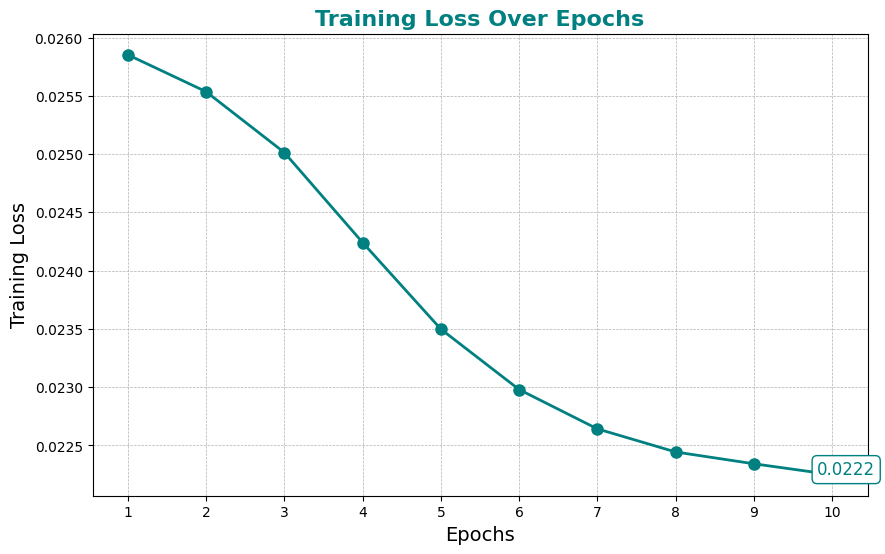

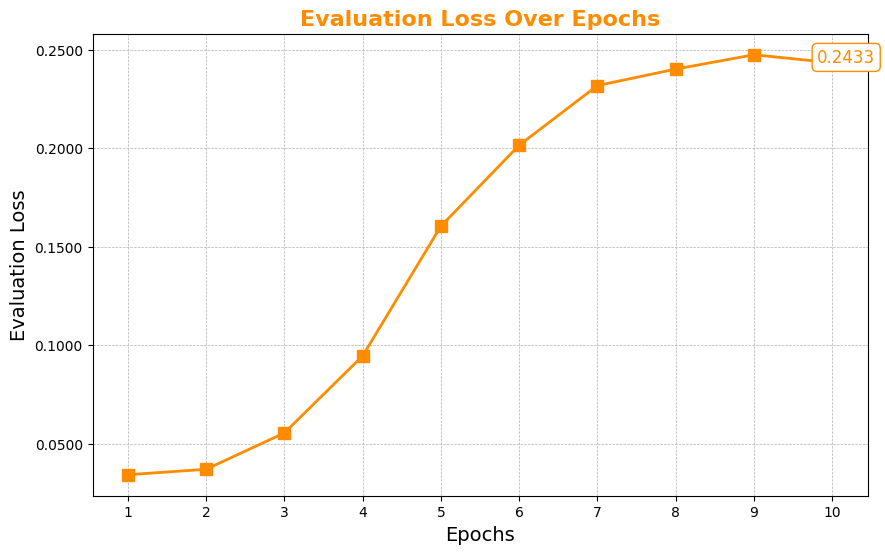

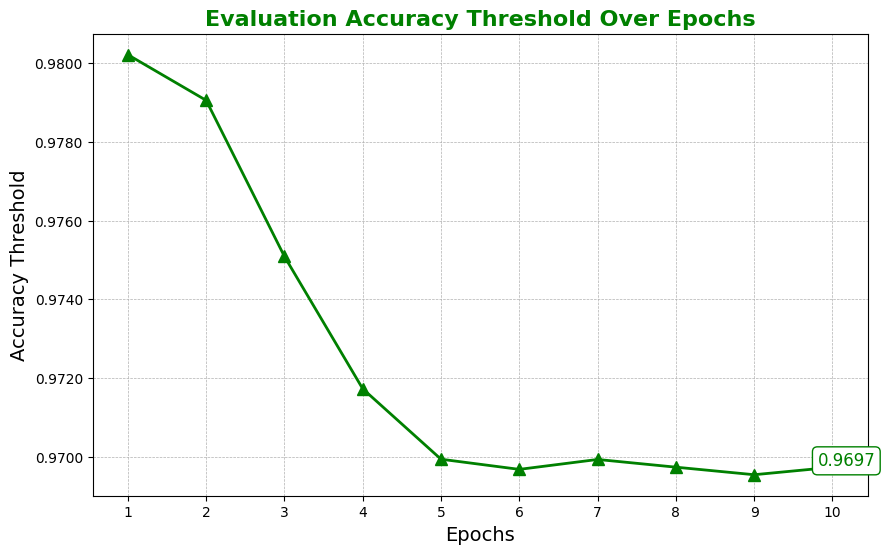

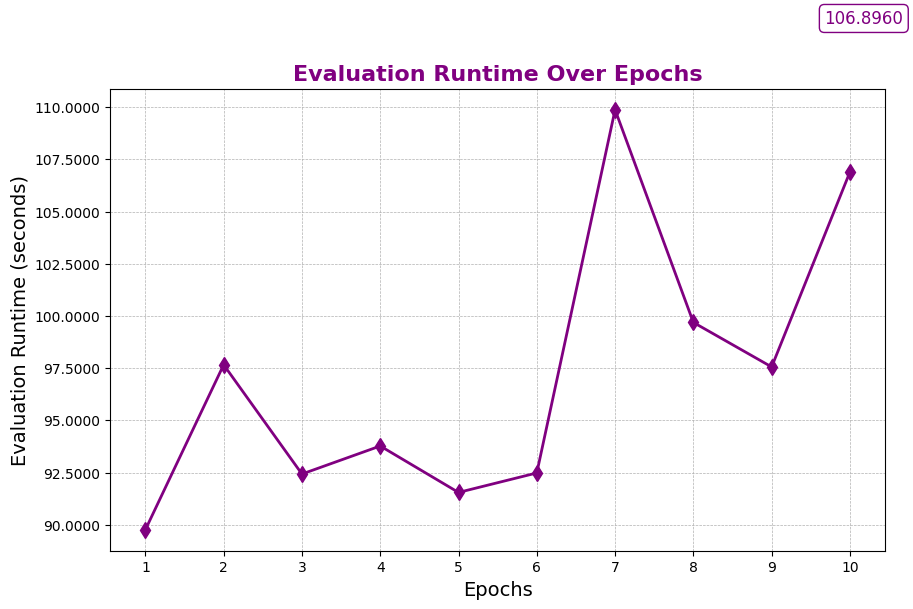

In [42]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming your training code ends with the following (from your Trainer):
# After each epoch, save relevant metrics to a list for plotting

epochs = []
train_loss = []
eval_loss = []
eval_accuracy_thresh = []
eval_runtime = []

# Mock training and evaluation metrics
for epoch in range(1, 11):  # Assume 3 epochs for example
    # Assuming metrics is like dictionary from Trainer's output for each epoch
    metrics = trainer.evaluate()
    epochs.append(epoch)
    eval_loss.append(metrics['eval_loss'])
    eval_accuracy_thresh.append(metrics['eval_accuracy_thresh'])
    eval_runtime.append(metrics['eval_runtime'])
    
    train_metrics = trainer.train()
    train_loss.append(train_metrics.training_loss)  # Access as an attribute

# Define a function to enhance each plot's presentation
def create_enhanced_plot(x, y, title, xlabel, ylabel, color, marker, annotate=True):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker=marker, linestyle='-', color=color, linewidth=2, markersize=8)
    
    # Add grid and set the style
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
    
    # Add labels and title with enhanced styling
    plt.title(title, fontsize=16, fontweight='bold', color=color)
    plt.xlabel(xlabel, fontsize=14, fontweight='medium')
    plt.ylabel(ylabel, fontsize=14, fontweight='medium')
    
    # Add annotations for final values if requested
    if annotate:
        plt.annotate(f'{y[-1]:.4f}', xy=(x[-1], y[-1]), xytext=(x[-1], y[-1] + 0.05),
                     textcoords="offset points", ha='center', fontsize=12, color=color,
                     bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor="white"))
    
    # Customize tick formatting for better readability
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.4f}'))
    plt.show()

# Create the enhanced plots with the defined function
create_enhanced_plot(epochs, train_loss, 
                     title="Training Loss Over Epochs", 
                     xlabel="Epochs", ylabel="Training Loss", 
                     color="teal", marker="o")

create_enhanced_plot(epochs, eval_loss, 
                     title="Evaluation Loss Over Epochs", 
                     xlabel="Epochs", ylabel="Evaluation Loss", 
                     color="darkorange", marker="s")

create_enhanced_plot(epochs, eval_accuracy_thresh, 
                     title="Evaluation Accuracy Threshold Over Epochs", 
                     xlabel="Epochs", ylabel="Accuracy Threshold", 
                     color="green", marker="^")

create_enhanced_plot(epochs, eval_runtime, 
                     title="Evaluation Runtime Over Epochs", 
                     xlabel="Epochs", ylabel="Evaluation Runtime (seconds)", 
                     color="purple", marker="d")

